In [1]:
###########################################################################################################################
#
# Antonio Vieira da Silva Neto - NUSP  5690149 - Doutorando em Ciências
# Henrique Lefundes da Silva   - NUSP 11808280 - Pesquisador de Iniciação Científica e Graduando em Engenharia Elétrica
#
# Escola Politécnica da Universidade de São Paulo
# Programa de Pós-Graduação em Engenharia Elétrica
# Departamento de Engenharia de Computação e Sistemas Digitais
# Área de Concentração: Confiabilidade e Segurança
#
# Tese de Doutorado: Safety ArtISt: Um Método para a Garantia de Segurança Crítica de Sistemas com Inteligência Artificial
#
# Estudo de Caso 4 - Sistema de Controle de Frenagem de Veículos
#
# Arquivo para geração do modelo base de IA
#
###########################################################################################################################

###########################################################################################################################
#
# Tabela de Controle de Versões do Código
#
#--------|-------------------|------------------------------|--------------------------------------------------------------
# Versão | Data (dd/mm/aaaa) | Autor                        | Descrição da Versão
#--------|-------------------|------------------------------|--------------------------------------------------------------
#   01   |    28/07/2022     | Henrique Lefundes da Silva   | Versão inicial.
#--------|-------------------|------------------------------|--------------------------------------------------------------
#   02   |    04/08/2022     | Henrique Lefundes da Silva   | Testes com diferentes datasets; função de testes automáticos;
#        |                   |                              | Árvore com dataset estraficado.
#--------|-------------------|------------------------------|--------------------------------------------------------------
#   03   |    29/12/2022     | Henrique Lefundes da Silva   | Multiplas árvores criadas, com diferentes tipos de estrafica-
#        |                   |                              | ção; função de votação de saídas; conversão das árvores uti-
#        |                   |                              | lizando o Conifer; Análise de erros da floresta aletória em 
#        |                   |                              | HDL; Análise da influência da precisão no erro.
#--------|-------------------|------------------------------|--------------------------------------------------------------
#   04   |    20/01/2023     | Henrique Lefundes da Silva   | Novas árvores criadas; segunda floresta criada para outro FGPA;
#        |                   |                              | Implementação de funções para votação considerando FPGA 1 e 2;
#        |                   |                              | Análise do uso de LUT's de para diferentes max_depth;
#        |                   |                              | Verificação da função de conversão criada.
#--------|-------------------|------------------------------|--------------------------------------------------------------
#   05   |    16/02/2023     | Henrique Lefundes da Silva   | Análise da diminuição do max_depth das árvores 1 e 5; Análise
#        |                   |                              | das técnicas de votação; Exemplo menor gerado para análise no
#        |                   |                              | Quartus; Análise das LUTs para diferentes precisões
#--------|-------------------|------------------------------|--------------------------------------------------------------
###########################################################################################################################

# Importação de Bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report 
from scipy.stats import mode

In [2]:
# Pré-processamento dos dados (pre_processing)

def pre_processing(address):
    dataColumns = ["Distância Ruidosa", "Velocidade Ruidosa", "Capacidade de Frenagem Ruidosa",
                    "Decisão"]
    
    dataset = pd.read_csv(address, header = None, names = dataColumns)
    
    return dataset

In [3]:
# Função criada para automatizar o processo de testes para diferentes datasets, 
# caso queira testar a árvore no dataset de testes 1, basta chamar automatic_test(1)
# Nome padrão dos datasets de teste: DatasetTX, onde X corresponde a numeração do dataset

def automatic_test(dataset_test_number, decision_tree): 
    # Lê base de dados 
    pp_dataset_test = pre_processing(f"./Datasets/DatasetT{dataset_test_number}.csv")
    
    # Define entradas e saída
    pp_data_inputs_test = pp_dataset_test.drop(columns = ['Decisão'])
    pp_data_outputs_test = pp_dataset_test[['Decisão']]

    # Valores preditos pela árvore treinada
    predicted_apply_brakes = decision_tree.predict(pp_data_inputs_test)

    # Métricas de performance
    finalAccuracy = accuracy_score(pp_data_outputs_test, predicted_apply_brakes)
    finalPrecision = precision_score(pp_data_outputs_test, predicted_apply_brakes)
    finalRecall = recall_score(pp_data_outputs_test, predicted_apply_brakes)
    finalF1 = f1_score(pp_data_outputs_test, predicted_apply_brakes)
    finalConfusionMatrix = confusion_matrix(pp_data_outputs_test, predicted_apply_brakes)
    finalClassificationReport = classification_report(pp_data_outputs_test, predicted_apply_brakes)

    # Imprime resultados finais
    print(f'******** Resultados DatasetT{dataset_test_number} ********')
    print('Accuracy:', finalAccuracy*100)
    print('Precision:', finalPrecision*100)
    print('Recall:', finalRecall*100)
    print('F1-Score:', finalF1*100)
    print(finalConfusionMatrix)
    ConfusionMatrixDisplay(finalConfusionMatrix).plot()
    plt.show()

    return finalAccuracy, finalPrecision, finalRecall

In [4]:
def voting(dataset, classifiers):
    pp_dataset_test = pre_processing(dataset)
    
    # Define entradas e saída
    pp_data_inputs_test = pp_dataset_test.drop(columns = ['Decisão'])

    lines = len(pp_data_inputs_test)
    columns = len(classifiers)

    decision_tree_inputs = np.zeros((lines,columns))

    for i in range(len(classifiers)):
        decision_tree_inputs[:,i] = classifiers[i].predict(pp_data_inputs_test)

    final_prediction = np.zeros((lines))

    for i in range(len(pp_data_inputs_test)):
        final_prediction[i] = mode(decision_tree_inputs[i], keepdims = False)[0]

    return final_prediction

<h1>decision_tree_1</h1>

In [5]:
# Realiza a leitura do arquivo CSV
# O arquivo se encontra numa pasta dentro do diretório deste programa:
# ./Árvore de Decisão/Dataset/Dataset.csv
pp_dataset = pre_processing("./Datasets/DatasetT&V.csv")

#Define as entradas e as saídas do dataset
pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
display(pp_data_inputs)

pp_data_outputs = pp_dataset[['Decisão']]
display(pp_data_outputs)


,Distância Ruidosa,Velocidade Ruidosa,Capacidade de Frenagem Ruidosa
0,0.000000,0.000000,1.3950
1,0.000000,0.000000,1.1625
2,1.579846,0.000000,0.9300
3,0.282185,0.000000,0.7800
4,0.394876,0.000000,0.6500
...,...,...,...
57280,2000.433820,26.977928,1.3950
57281,1999.988138,28.886308,1.1625
57282,1998.246886,28.409583,0.9300
57283,2002.044078,27.358991,0.7800


,Decisão
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
57280,0.0
57281,0.0
57282,0.0
57283,0.0


In [ ]:
random_state = 1

# Definição dos hiperparâmetros

criterion = ['entropy', 'gini']

splitter = ['best', 'random']

max_depth = [int(x) for x in np.arange(1, 22, step = 2)] # max_depth já limitado

min_samples_split = [int(x) for x in np.arange(2, 18, step = 3)]

min_samples_leaf = [int(x) for x in np.arange(1, 18, step = 3)]

min_weight_fraction_leaf = [float(x) for x in np.linspace(0,0.5,5)] # não houve 1 RandomSearch que fosse diferente de 0

max_leaf_nodes = [int(x) for x in np.arange(200, 510, step = 10)]
max_leaf_nodes.append(None)

max_features = [int(x) for x in np.arange(1, 4, step = 1)] 
max_features.append('log2')
max_features.append('sqrt')
max_features.append(None)

combinations = len(criterion)*len(splitter)*len(max_depth)*len(min_samples_leaf)*len(min_samples_split)*len(min_weight_fraction_leaf)*len(max_leaf_nodes)*len(max_features)

print('Número de combinações possíveis:', combinations)

hyperparameters_settings = {'criterion'                : criterion,
                            'splitter'                 : splitter,
                            'max_depth'                : max_depth,
                            'min_samples_split'        : min_samples_split,
                            'min_samples_leaf'         : min_samples_leaf,
                            'min_weight_fraction_leaf' : min_weight_fraction_leaf,
                            'max_leaf_nodes'           : max_leaf_nodes,
                            'max_features'             : max_features
                           }

print(hyperparameters_settings)

# Metrica de performance
scoring = 'recall'

# Número de partições
k_fold = 10 
n_iter = 2500

print('Tempo estimado de processamento:', round((n_iter*10)/140,1), 'segundos')


In [ ]:
# Criação da árvore de decisão
starting_decision_tree = DecisionTreeClassifier()

# Optimização dos hiperparâmetros com RandomSearch
dtTries = RandomizedSearchCV(estimator = starting_decision_tree, param_distributions = hyperparameters_settings, scoring = scoring,
                            cv = KFold(n_splits = k_fold, shuffle = True), verbose = 3, n_jobs = -1, n_iter = n_iter)

# Teste com os hiperparâmetros encontrados
dtTries.fit(pp_data_inputs, pp_data_outputs)


In [ ]:
# Imprime valores ótimos dos hiperparâmetros
print(dtTries.best_params_)
print(k_fold,'- Fold Best recall-score: ', dtTries.best_score_*100)

In [ ]:
# Segunda iteração

splitter = ['best']

min_weight_fraction_leaf = [0]

min_samples_split = [int(x) for x in np.arange(2, 8, step = 1)]

min_samples_leaf = [int(x) for x in np.arange(1, 4, step = 1)]

max_leaf_nodes = [int(x) for x in np.arange(230, 280, step = 5)]

max_features = [2,3] 

max_depth = [int(x) for x in np.arange(15, 20, step = 1)]

criterion = ['entropy']

hyperparameters_settings = {'criterion'                : criterion,
                            'splitter'                 : splitter,
                            'max_depth'                : max_depth,
                            'min_samples_split'        : min_samples_split,
                            'min_samples_leaf'         : min_samples_leaf,
                            'min_weight_fraction_leaf' : min_weight_fraction_leaf,
                            'max_leaf_nodes'           : max_leaf_nodes,
                            'max_features'             : max_features
                           }

print(hyperparameters_settings)

# Metrica de performance
scoring = 'recall'

# Número de partições
k_fold = 10 

In [ ]:
# Optimização dos hiperparâmetros com GridSearch
dtTries = GridSearchCV(estimator = starting_decision_tree, param_grid = hyperparameters_settings, scoring = scoring,
                            cv = KFold(n_splits = k_fold, shuffle = True), verbose = 3, n_jobs = -1)

# Teste com os hiperparâmetros encontrados
dtTries.fit(pp_data_inputs, pp_data_outputs)

In [ ]:
# Imprime valores ótimos dos hiperparâmetros
print(dtTries.best_params_)
print(k_fold,'- Fold Best recall-score: ', dtTries.best_score_*100)

<h2>final_decision_tree_1</h2>

Accuracy: 99.22318233394432
Precision: 96.57293497363796
Recall: 95.64838990426458
F1-Score: 96.10843900306078
[[10269    39]
 [   50  1099]]


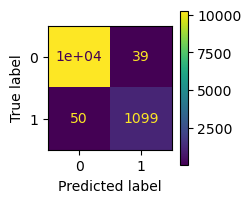

******** Resultados DatasetT1 ********
Accuracy: 99.35934363271363
Precision: 96.90596210672693
Recall: 96.72102706453852
F1-Score: 96.81340626899366
[[51343   178]
 [  189  5575]]


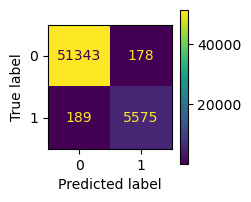

******** Resultados DatasetT2 ********
Accuracy: 99.30173692938816
Precision: 96.48180242634315
Recall: 96.58223455933378
F1-Score: 96.53199237038321
[[51318   203]
 [  197  5567]]


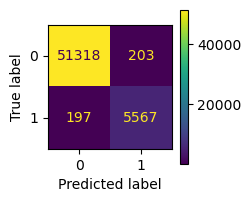

******** Resultados DatasetT3 ********
Accuracy: 99.37854586715545
Precision: 96.94444444444444
Recall: 96.87716863289383
F1-Score: 96.91079486289483
[[51345   176]
 [  180  5584]]


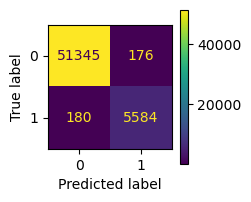

(0.9937854586715545, 0.9694444444444444, 0.9687716863289383)

In [6]:
# Árvore de decisão final
#final_decision_tree_1 = dtTries.best_estimator_

final_decision_tree_1 = DecisionTreeClassifier(criterion = 'entropy', 
                                            max_depth = 16, 
                                            max_features = 3, 
                                            max_leaf_nodes = 270, 
                                            min_samples_leaf = 3, 
                                            min_samples_split = 6,
                                            min_weight_fraction_leaf = 0, 
                                            splitter = 'best')

# Holdout test
inputsTrain, inputsTest, outputsTrain, outputsTest = train_test_split(pp_data_inputs, 
                                                                      pp_data_outputs,
                                                                      test_size = 0.2)

final_decision_tree_1.fit(inputsTrain, outputsTrain)

# Valores preditos pela árvore treinada
predicted_apply_brakes = final_decision_tree_1.predict(inputsTest)

# Métricas de performance
finalAccuracy = accuracy_score(outputsTest, predicted_apply_brakes)
finalPrecision = precision_score(outputsTest, predicted_apply_brakes)
finalRecall = recall_score(outputsTest, predicted_apply_brakes)
finalF1 = f1_score(outputsTest, predicted_apply_brakes)
finalConfusionMatrix = confusion_matrix(outputsTest, predicted_apply_brakes)
finalClassificationReport = classification_report(outputsTest, predicted_apply_brakes)

plt.rcParams['figure.figsize'] = [2, 2]
plt.rcParams['figure.dpi'] = 100
# Plot da árvore de decisão treinada, comentado para diminuir tempo de execução
# plot_tree(final_decision_tree)
# plt.show()

# Imprime resultados finais
print('Accuracy:', finalAccuracy*100)
print('Precision:', finalPrecision*100)
print('Recall:', finalRecall*100)
print('F1-Score:', finalF1*100)
print(finalConfusionMatrix)
ConfusionMatrixDisplay(finalConfusionMatrix).plot()
plt.show()

# Testes para DatasetT1, DatasetT2 e DatasetT3
automatic_test(1,final_decision_tree_1)
automatic_test(2,final_decision_tree_1)
automatic_test(3,final_decision_tree_1)

In [ ]:
# Teste para dataset sem ruído 
dataColumns = ['Distancia Ruidosa', 'Velocidade Ruidosa', 'Capacidade de Frenagem Ruidosa', 'Distancia', 'Velocidade', 
                'Capacidade de Frenagem', 'Decisão', 'Aceleracao', 'AW', 'AG', 'VH', 'VC', 'V50', 'DS', 'Decisao Ruidosa', 
                'Aceleracao Ruidosa', 'AW Ruidosa', 'AG Ruidosa', 'VH Ruidosa', 'VC Ruidosa', 'V50 Ruidosa', 'DS Ruidosa']
    
pp_dataset_test = pd.read_csv("./Datasets/DatasetT&VDebug.csv", header = None, names = dataColumns)

pp_data_inputs_test = pp_dataset_test[['Distancia', 'Velocidade', 'Capacidade de Frenagem']]
pp_data_inputs_test = pp_data_inputs_test.rename(columns={"Distancia":"Distância Ruidosa","Velocidade":"Velocidade Ruidosa", "Capacidade de Frenagem":"Capacidade de Frenagem Ruidosa"})

print(pp_data_inputs_test)

pp_data_outputs_test = pp_dataset_test[['Decisão']]

print(pp_data_outputs_test)



In [ ]:
# Valores preditos pela árvore treinada
predicted_apply_brakes = final_decision_tree_1.predict(pp_data_inputs_test)

# Métricas de performance
finalAccuracy = accuracy_score(pp_data_outputs_test, predicted_apply_brakes)
finalPrecision = precision_score(pp_data_outputs_test, predicted_apply_brakes)
finalRecall = recall_score(pp_data_outputs_test, predicted_apply_brakes)
finalF1 = f1_score(pp_data_outputs_test, predicted_apply_brakes)
finalConfusionMatrix = confusion_matrix(pp_data_outputs_test, predicted_apply_brakes)
finalClassificationReport = classification_report(pp_data_outputs_test, predicted_apply_brakes)

# Imprime resultados finais
print(f'******** Resultados dataset sem ruido ********')
print('Accuracy:', finalAccuracy*100)
print('Precision:', finalPrecision*100)
print('Recall:', finalRecall*100)
print('F1-Score:', finalF1*100)
print(finalConfusionMatrix)
ConfusionMatrixDisplay(finalConfusionMatrix).plot()
plt.show()  

<h1>decision_tree_2</h1>

In [7]:
pp_dataset = pre_processing("./Datasets/DatasetStratified80v3.csv")

pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
display(pp_data_inputs) #Entradas

pp_data_outputs = pp_dataset[['Decisão']]
display(pp_data_outputs) #Saídas

,Distância Ruidosa,Velocidade Ruidosa,Capacidade de Frenagem Ruidosa
0,1513.240000,19.404649,0.780
1,1579.179929,19.212684,1.395
2,140.877769,18.508253,0.780
3,131.171315,18.916247,1.395
4,1039.015117,3.290000,0.780
...,...,...,...
57280,540.216937,13.603871,0.930
57281,1547.625493,16.070486,1.395
57282,10.800206,4.257071,1.395
57283,1509.641991,11.400315,0.930


,Decisão
0,0.0
1,0.0
2,1.0
3,1.0
4,0.0
...,...
57280,0.0
57281,0.0
57282,1.0
57283,0.0


In [ ]:
random_state = 1
# Definição dos hiperparâmetros

criterion = ['entropy', 'gini']

splitter = ['best', 'random']

max_depth = [int(x) for x in np.arange(1, 10, step = 1)] # max_depth já foi limitado

min_samples_split = [int(x) for x in np.arange(2, 18, step = 3)]

min_samples_leaf = [int(x) for x in np.arange(1, 18, step = 3)]

min_weight_fraction_leaf = [0] # Ajustado o intervalo, o peso máximo aceito é 0.5, entretanto todas as RSearch dão 0

max_leaf_nodes = [int(x) for x in np.arange(200, 510, step = 10)]
max_leaf_nodes.append(None)

max_features = [int(x) for x in np.arange(1, 4, step = 1)] 
max_features.append('log2')
max_features.append('sqrt')
max_features.append(None)

combinations = len(criterion)*len(splitter)*len(max_depth)*len(min_samples_leaf)*len(min_samples_split)*len(min_weight_fraction_leaf)*len(max_leaf_nodes)*len(max_features)

print('Número de combinações possíveis:', combinations)

hyperparameters_settings = {'criterion'                : criterion,
                            'splitter'                 : splitter,
                            'max_depth'                : max_depth,
                            'min_samples_split'        : min_samples_split,
                            'min_samples_leaf'         : min_samples_leaf,
                            'min_weight_fraction_leaf' : min_weight_fraction_leaf,
                            'max_leaf_nodes'           : max_leaf_nodes,
                            'max_features'             : max_features
                           }

print(hyperparameters_settings)

# Metrica de performance
scoring = 'recall'

# Número de partições
k_fold = 10 

# Número de iterações
n_iter = 2500 

print('Tempo estimado de processamento:', round((n_iter*10)/140,1), 'segundos')

In [ ]:
# Criação da árvore de decisão
starting_decision_tree = DecisionTreeClassifier()

# Optimização dos hiperparâmetros com RandomSearch
dtTries = RandomizedSearchCV(estimator = starting_decision_tree, param_distributions = hyperparameters_settings, scoring = scoring,
                            cv = KFold(n_splits = k_fold, shuffle = True), verbose = 1, n_jobs = -1, n_iter = n_iter)

# Teste com os hiperparâmetros encontrados
dtTries.fit(pp_data_inputs, pp_data_outputs)


In [ ]:
print(dtTries.best_params_) 
print(k_fold,'- Fold Best recall-score: ', dtTries.best_score_*100)

In [ ]:
# Segunda iteração

splitter = ['best']

min_weight_fraction_leaf = [0] 

min_samples_split = [int(x) for x in np.arange(5, 11, step = 1)]

min_samples_leaf = [int(x) for x in np.arange(2, 7, step = 1)]

max_leaf_nodes = [int(x) for x in np.arange(460, 505, step = 5)]

max_features = [None] 

max_depth = [int(x) for x in np.arange(5, 10, step = 1)]

criterion = ['entropy']

hyperparameters_settings = {'criterion'                : criterion,
                            'splitter'                 : splitter,
                            'max_depth'                : max_depth,
                            'min_samples_split'        : min_samples_split,
                            'min_samples_leaf'         : min_samples_leaf,
                            'min_weight_fraction_leaf' : min_weight_fraction_leaf,
                            'max_leaf_nodes'           : max_leaf_nodes,
                            'max_features'             : max_features
                           }

print(hyperparameters_settings)

# Metrica de performance
scoring = 'recall'

# Número de partições
k_fold = 10 

In [ ]:
# Optimização dos hiperparâmetros com GridSearch
dtTries = GridSearchCV(estimator = starting_decision_tree, param_grid = hyperparameters_settings, scoring = scoring,
                            cv = KFold(n_splits = k_fold, shuffle = True), verbose = 1, n_jobs = -1)

# Teste com os hiperparâmetros encontrados
dtTries.fit(pp_data_inputs, pp_data_outputs)

In [ ]:
print(dtTries.best_params_)
print(k_fold,'- Fold Best recall-score: ', dtTries.best_score_*100)

<h2>final_decision_tree_2</h2>

Accuracy: 98.44636466788863
Precision: 95.15657620041755
Recall: 97.35155916275096
F1-Score: 96.24155405405406
[[9000  116]
 [  62 2279]]


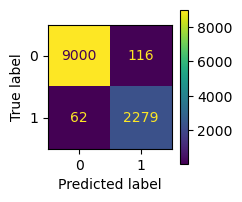

******** Resultados DatasetT1 ********
Accuracy: 98.96133368246487
Precision: 92.14087722158813
Recall: 98.03955586398334
F1-Score: 94.99873917794402
[[51039   482]
 [  113  5651]]


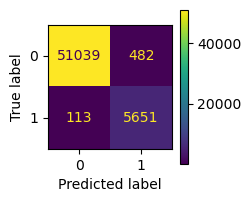

******** Resultados DatasetT2 ********
Accuracy: 98.92816618661081
Precision: 91.81552452094836
Recall: 98.09160305343512
F1-Score: 94.84985740647542
[[51017   504]
 [  110  5654]]


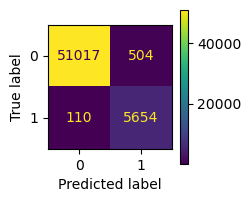

******** Resultados DatasetT3 ********
Accuracy: 98.93514881731691
Precision: 92.08033964728935
Recall: 97.83136710617627
F1-Score: 94.86877523553163
[[51036   485]
 [  125  5639]]


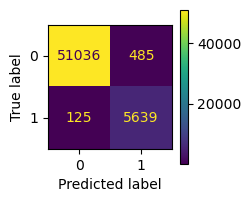

(0.9893514881731692, 0.9208033964728936, 0.9783136710617627)

In [8]:
#final_decision_tree_2 = dtTries.best_estimator_

final_decision_tree_2 = DecisionTreeClassifier(criterion = 'entropy', 
                                            max_depth = 8, 
                                            max_features = None, 
                                            max_leaf_nodes = 465, 
                                            min_samples_leaf = 3, 
                                            min_samples_split = 8,
                                            min_weight_fraction_leaf = 0, 
                                            splitter = 'best')

# Holdout test
inputsTrain, inputsTest, outputsTrain, outputsTest = train_test_split(pp_data_inputs, 
                                                                      pp_data_outputs,
                                                                      test_size = 0.20) # 20% dos dados para teste, com 50% das saídas sendo 0

final_decision_tree_2.fit(inputsTrain, outputsTrain)

# Valores preditos pela árvore treinada
predicted_apply_brakes = final_decision_tree_2.predict(inputsTest)

# Métricas de performance
finalAccuracy = accuracy_score(outputsTest, predicted_apply_brakes)
finalPrecision = precision_score(outputsTest, predicted_apply_brakes)
finalRecall = recall_score(outputsTest, predicted_apply_brakes)
finalF1 = f1_score(outputsTest, predicted_apply_brakes)
finalConfusionMatrix = confusion_matrix(outputsTest, predicted_apply_brakes)

# Imprime resultados finais
print('Accuracy:', finalAccuracy*100)
print('Precision:', finalPrecision*100)
print('Recall:', finalRecall*100)
print('F1-Score:', finalF1*100)
print(finalConfusionMatrix)
ConfusionMatrixDisplay(finalConfusionMatrix).plot()
plt.show()

automatic_test(1, final_decision_tree_2)
automatic_test(2, final_decision_tree_2)
automatic_test(3, final_decision_tree_2)

In [ ]:
# Teste para dataset sem ruído 
dataColumns = ['Distancia Ruidosa', 'Velocidade Ruidosa', 'Capacidade de Frenagem Ruidosa', 'Distancia', 'Velocidade', 
                'Capacidade de Frenagem', 'Decisão', 'Aceleracao', 'AW', 'AG', 'VH', 'VC', 'V50', 'DS', 'Decisao Ruidosa', 
                'Aceleracao Ruidosa', 'AW Ruidosa', 'AG Ruidosa', 'VH Ruidosa', 'VC Ruidosa', 'V50 Ruidosa', 'DS Ruidosa']
    
pp_dataset_test = pd.read_csv("./Datasets/DatasetT&VDebug.csv", header = None, names = dataColumns)

pp_data_inputs_test = pp_dataset_test[['Distancia', 'Velocidade', 'Capacidade de Frenagem']]
pp_data_inputs_test = pp_data_inputs_test.rename(columns={"Distancia":"Distância Ruidosa","Velocidade":"Velocidade Ruidosa", "Capacidade de Frenagem":"Capacidade de Frenagem Ruidosa"})

print(pp_data_inputs_test)

pp_data_outputs_test = pp_dataset_test[['Decisão']]

print(pp_data_outputs_test)


In [ ]:
# Valores preditos pela árvore treinada
predicted_apply_brakes = final_decision_tree_2.predict(pp_data_inputs_test)

# Métricas de performance
finalAccuracy = accuracy_score(pp_data_outputs_test, predicted_apply_brakes)
finalPrecision = precision_score(pp_data_outputs_test, predicted_apply_brakes)
finalRecall = recall_score(pp_data_outputs_test, predicted_apply_brakes)
finalF1 = f1_score(pp_data_outputs_test, predicted_apply_brakes)
finalConfusionMatrix = confusion_matrix(pp_data_outputs_test, predicted_apply_brakes)
finalClassificationReport = classification_report(pp_data_outputs_test, predicted_apply_brakes)

# Imprime resultados finais
print(f'******** Resultados dataset sem ruido ********')
print('Accuracy:', finalAccuracy*100)
print('Precision:', finalPrecision*100)
print('Recall:', finalRecall*100)
print('F1-Score:', finalF1*100)
print(finalConfusionMatrix)
ConfusionMatrixDisplay(finalConfusionMatrix).plot()
plt.show()  

<h1>decision_tree_3</h1>

In [9]:
pp_dataset = pre_processing("./Datasets/DatasetStratified65.csv")

pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
display(pp_data_inputs) #Entradas

pp_data_outputs = pp_dataset[['Decisão']]
display(pp_data_outputs) #Saídas

,Distância Ruidosa,Velocidade Ruidosa,Capacidade de Frenagem Ruidosa
0,190.676084,20.160869,0.650
1,290.388642,19.938837,0.930
2,1850.616647,5.037671,0.930
3,1619.005724,22.157538,0.780
4,441.238864,19.758767,1.395
...,...,...,...
57280,1340.535167,17.899054,1.395
57281,1848.422947,8.703425,0.780
57282,781.489436,18.437710,0.650
57283,138.397335,23.615608,0.930


,Decisão
0,1.0
1,1.0
2,0.0
3,0.0
4,0.0
...,...
57280,0.0
57281,0.0
57282,0.0
57283,1.0


In [ ]:
random_state = 1

# Definição dos hiperparâmetros

criterion = ['entropy', 'gini']

splitter = ['best', 'random']

max_depth = [int(x) for x in np.arange(1, 10, step = 2)] # max_depth já foi limitado

min_samples_split = [int(x) for x in np.arange(2, 18, step = 3)]

min_samples_leaf = [int(x) for x in np.arange(1, 18, step = 3)]

min_weight_fraction_leaf = [float(x) for x in np.linspace(0,0.5,5)] # Ajustado o intervalo, o peso máximo aceito é 0.5, entretanto todas as RSearch dão 0

max_leaf_nodes = [int(x) for x in np.arange(200, 510, step = 10)]
max_leaf_nodes.append(None)

max_features = [int(x) for x in np.arange(1, 4, step = 1)] 
max_features.append('log2')
max_features.append('sqrt')
max_features.append(None)

combinations = len(criterion)*len(splitter)*len(max_depth)*len(min_samples_leaf)*len(min_samples_split)*len(min_weight_fraction_leaf)*len(max_leaf_nodes)*len(max_features)

print('Número de combinações possíveis:', combinations)

hyperparameters_settings = {'criterion'                : criterion,
                            'splitter'                 : splitter,
                            'max_depth'                : max_depth,
                            'min_samples_split'        : min_samples_split,
                            'min_samples_leaf'         : min_samples_leaf,
                            'min_weight_fraction_leaf' : min_weight_fraction_leaf,
                            'max_leaf_nodes'           : max_leaf_nodes,
                            'max_features'             : max_features
                           }

print(hyperparameters_settings)

# Metrica de performance
scoring = 'recall'

# Número de partições
k_fold = 10 

# Número de iterações
n_iter = 2500 

print('Tempo estimado de processamento:', round((n_iter*10)/140,1), 'segundos')

In [ ]:
# Criação da árvore de decisão
starting_decision_tree = DecisionTreeClassifier()

# Optimização dos hiperparâmetros com RandomSearch
dtTries = RandomizedSearchCV(estimator = starting_decision_tree, param_distributions = hyperparameters_settings, scoring = scoring,
                            cv = KFold(n_splits = k_fold, shuffle = True), verbose = 1, n_jobs = -1, n_iter = n_iter)

# Teste com os hiperparâmetros encontrados
dtTries.fit(pp_data_inputs, pp_data_outputs)

In [ ]:
print(dtTries.best_params_)
print(k_fold,'- Fold Best recall-score: ', dtTries.best_score_*100)

In [ ]:
# Segunda iteração

splitter = ['best']

min_weight_fraction_leaf = [0]

min_samples_split = [int(x) for x in np.arange(2, 6, step = 1)]

min_samples_leaf = [int(x) for x in np.arange(1, 5, step = 1)]

max_leaf_nodes = [int(x) for x in np.arange(470, 515, step = 5)]

max_features = [None] 

max_depth = [int(x) for x in np.arange(3, 10, step = 1)]

criterion = ['gini']

hyperparameters_settings = {'criterion'                : criterion,
                            'splitter'                 : splitter,
                            'max_depth'                : max_depth,
                            'min_samples_split'        : min_samples_split,
                            'min_samples_leaf'         : min_samples_leaf,
                            'min_weight_fraction_leaf' : min_weight_fraction_leaf,
                            'max_leaf_nodes'           : max_leaf_nodes,
                            'max_features'             : max_features
                           }

print(hyperparameters_settings)

# Metrica de performance
scoring = 'recall'

# Número de partições
k_fold = 10 

In [ ]:
# Optimização dos hiperparâmetros com GridSearch
dtTries = GridSearchCV(estimator = starting_decision_tree, param_grid = hyperparameters_settings, scoring = scoring,
                            cv = KFold(n_splits = k_fold, shuffle = True), verbose = 1, n_jobs = -1)

# Teste com os hiperparâmetros encontrados
dtTries.fit(pp_data_inputs, pp_data_outputs)

In [ ]:
print(dtTries.best_params_)
print(k_fold,'- Fold Best recall-score: ', dtTries.best_score_*100)

<h2>final_decision_tree_3</h2>

Accuracy: 98.81295277995986
Precision: 97.83037475345168
Recall: 98.80478087649402
F1-Score: 98.31516352824579
[[7353   88]
 [  48 3968]]


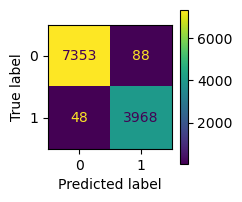

******** Resultados DatasetT1 ********
Accuracy: 98.88801606005062
Precision: 90.80057297469362
Recall: 98.9764052741152
F1-Score: 94.712376525276
[[50943   578]
 [   59  5705]]


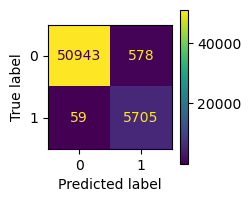

******** Resultados DatasetT2 ********
Accuracy: 98.88976171772715
Precision: 90.828025477707
Recall: 98.95905621096462
F1-Score: 94.71936233809367
[[50945   576]
 [   60  5704]]


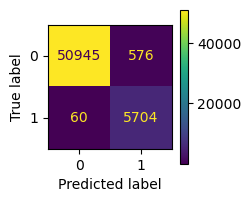

******** Resultados DatasetT3 ********
Accuracy: 98.86706816793227
Precision: 90.62748212867355
Recall: 98.9764052741152
F1-Score: 94.61812753959698
[[50931   590]
 [   59  5705]]


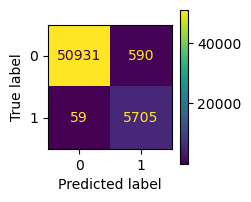

(0.9886706816793227, 0.9062748212867355, 0.989764052741152)

In [10]:
#final_decision_tree_3 = dtTries.best_estimator_

final_decision_tree_3 = DecisionTreeClassifier(criterion = 'gini', 
                                            max_depth = 8, 
                                            max_features = None, 
                                            max_leaf_nodes = 470, 
                                            min_samples_leaf = 1, 
                                            min_samples_split = 4,
                                            min_weight_fraction_leaf = 0, 
                                            splitter = 'best')

# Holdout test
inputsTrain, inputsTest, outputsTrain, outputsTest = train_test_split(pp_data_inputs, 
                                                                      pp_data_outputs,
                                                                      test_size = 0.2) # 20% dos dados para teste, com 50% das saídas sendo 0

final_decision_tree_3.fit(inputsTrain, outputsTrain)

# Valores preditos pela árvore treinada
predicted_apply_brakes = final_decision_tree_3.predict(inputsTest)

# Métricas de performance
finalAccuracy = accuracy_score(outputsTest, predicted_apply_brakes)
finalPrecision = precision_score(outputsTest, predicted_apply_brakes)
finalRecall = recall_score(outputsTest, predicted_apply_brakes)
finalF1 = f1_score(outputsTest, predicted_apply_brakes)
finalConfusionMatrix = confusion_matrix(outputsTest, predicted_apply_brakes)

# Imprime resultados finais
print('Accuracy:', finalAccuracy*100)
print('Precision:', finalPrecision*100)
print('Recall:', finalRecall*100)
print('F1-Score:', finalF1*100)
print(finalConfusionMatrix)
ConfusionMatrixDisplay(finalConfusionMatrix).plot()
plt.show()

automatic_test(1, final_decision_tree_3)
automatic_test(2, final_decision_tree_3)
automatic_test(3, final_decision_tree_3)

In [ ]:
# Teste para dataset sem ruído 
dataColumns = ['Distancia Ruidosa', 'Velocidade Ruidosa', 'Capacidade de Frenagem Ruidosa', 'Distancia', 'Velocidade', 
                'Capacidade de Frenagem', 'Decisão', 'Aceleracao', 'AW', 'AG', 'VH', 'VC', 'V50', 'DS', 'Decisao Ruidosa', 
                'Aceleracao Ruidosa', 'AW Ruidosa', 'AG Ruidosa', 'VH Ruidosa', 'VC Ruidosa', 'V50 Ruidosa', 'DS Ruidosa']
    
pp_dataset_test = pd.read_csv("./Datasets/DatasetT&VDebug.csv", header = None, names = dataColumns)

pp_data_inputs_test = pp_dataset_test[['Distancia', 'Velocidade', 'Capacidade de Frenagem']]
pp_data_inputs_test = pp_data_inputs_test.rename(columns={"Distancia":"Distância Ruidosa","Velocidade":"Velocidade Ruidosa", "Capacidade de Frenagem":"Capacidade de Frenagem Ruidosa"})

print(pp_data_inputs_test)

pp_data_outputs_test = pp_dataset_test[['Decisão']]

print(pp_data_outputs_test)

In [ ]:
# Valores preditos pela árvore treinada
predicted_apply_brakes = final_decision_tree_3.predict(pp_data_inputs_test)

# Métricas de performance
finalAccuracy = accuracy_score(pp_data_outputs_test, predicted_apply_brakes)
finalPrecision = precision_score(pp_data_outputs_test, predicted_apply_brakes)
finalRecall = recall_score(pp_data_outputs_test, predicted_apply_brakes)
finalF1 = f1_score(pp_data_outputs_test, predicted_apply_brakes)
finalConfusionMatrix = confusion_matrix(pp_data_outputs_test, predicted_apply_brakes)
finalClassificationReport = classification_report(pp_data_outputs_test, predicted_apply_brakes)

# Imprime resultados finais
print(f'******** Resultados dataset sem ruido ********')
print('Accuracy:', finalAccuracy*100)
print('Precision:', finalPrecision*100)
print('Recall:', finalRecall*100)
print('F1-Score:', finalF1*100)
print(finalConfusionMatrix)
ConfusionMatrixDisplay(finalConfusionMatrix).plot()
plt.show()  

<h1>decision_tree_4</h1>

In [11]:
pp_dataset = pre_processing("./Datasets/DatasetStratified55.csv")

pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
display(pp_data_inputs) #Entradas

pp_data_outputs = pp_dataset[['Decisão']]
display(pp_data_outputs) #Saídas

,Distância Ruidosa,Velocidade Ruidosa,Capacidade de Frenagem Ruidosa
0,629.046485,10.841248,0.7800
1,1661.711167,8.579126,1.3950
2,1909.676463,26.106402,1.1625
3,1779.527581,20.826739,0.6500
4,428.645448,12.190000,0.9300
...,...,...,...
57280,1671.136424,21.191721,1.1625
57281,148.502272,7.916755,0.9300
57282,960.377975,22.262636,0.9300
57283,157.388917,26.535720,0.7800


,Decisão
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
57280,0.0
57281,0.0
57282,0.0
57283,1.0


In [ ]:
random_state = 1

# Definição dos hiperparâmetros

criterion = ['entropy', 'gini']

splitter = ['best', 'random']

max_depth = [int(x) for x in np.arange(1, 9, step = 1)] # max_depth já foi limitado

min_samples_split = [int(x) for x in np.arange(2, 18, step = 3)]

min_samples_leaf = [int(x) for x in np.arange(1, 18, step = 3)]

min_weight_fraction_leaf = [float(x) for x in np.linspace(0,0.5,5)] # Ajustado o intervalo, o peso máximo aceito é 0.5, entretanto todas as RSearch dão 0

max_leaf_nodes = [int(x) for x in np.arange(200, 510, step = 10)]
max_leaf_nodes.append(None)

max_features = [int(x) for x in np.arange(1, 4, step = 1)] 
max_features.append('log2')
max_features.append('sqrt')
max_features.append(None)

combinations = len(criterion)*len(splitter)*len(max_depth)*len(min_samples_leaf)*len(min_samples_split)*len(min_weight_fraction_leaf)*len(max_leaf_nodes)*len(max_features)

print('Número de combinações possíveis:', combinations)

hyperparameters_settings = {'criterion'                : criterion,
                            'splitter'                 : splitter,
                            'max_depth'                : max_depth,
                            'min_samples_split'        : min_samples_split,
                            'min_samples_leaf'         : min_samples_leaf,
                            'min_weight_fraction_leaf' : min_weight_fraction_leaf,
                            'max_leaf_nodes'           : max_leaf_nodes,
                            'max_features'             : max_features
                           }

print(hyperparameters_settings)

# Metrica de performance
scoring = 'recall'

# Número de partições
k_fold = 10 

# Número de iterações
n_iter = 2500

print('Tempo estimado de processamento:', round((n_iter*10)/140,1), 'segundos')

In [ ]:
# Criação da árvore de decisão
starting_decision_tree = DecisionTreeClassifier()

# Optimização dos hiperparâmetros com RandomSearch
dtTries = RandomizedSearchCV(estimator = starting_decision_tree, param_distributions = hyperparameters_settings, scoring = scoring,
                            cv = KFold(n_splits = k_fold, shuffle = True), verbose = 1, n_jobs = -1, n_iter = n_iter)

# Teste com os hiperparâmetros encontrados
dtTries.fit(pp_data_inputs, pp_data_outputs)

In [ ]:
# Imprime valores ótimos dos hiperparâmetros
print(dtTries.best_params_)
print(k_fold,'- Fold Best recall-score: ', dtTries.best_score_*100)

In [ ]:
# Segunda iteração

splitter = ['best']

min_weight_fraction_leaf = [0] 

min_samples_split = [int(x) for x in np.arange(8, 16, step = 1)]

min_samples_leaf = [int(x) for x in np.arange(2, 7, step = 1)]

max_leaf_nodes = [int(x) for x in np.arange(480, 525, step = 5)]

max_features = [None]

max_depth = [int(x) for x in np.arange(4, 9, step = 1)]

criterion = ['gini']

hyperparameters_settings = {'criterion'                : criterion,
                            'splitter'                 : splitter,
                            'max_depth'                : max_depth,
                            'min_samples_split'        : min_samples_split,
                            'min_samples_leaf'         : min_samples_leaf,
                            'min_weight_fraction_leaf' : min_weight_fraction_leaf,
                            'max_leaf_nodes'           : max_leaf_nodes,
                            'max_features'             : max_features
                           }

print(hyperparameters_settings)

# Metrica de performance
scoring = 'recall'

# Número de partições
k_fold = 10 

In [ ]:
# Optimização dos hiperparâmetros com GridSearch
dtTries = GridSearchCV(estimator = starting_decision_tree, param_grid = hyperparameters_settings, scoring = scoring,
                            cv = KFold(n_splits = k_fold, shuffle = True), verbose = 1, n_jobs = -1)

# Teste com os hiperparâmetros encontrados
dtTries.fit(pp_data_inputs, pp_data_outputs)

In [ ]:
# Imprime valores ótimos dos hiperparâmetros
print(dtTries.best_params_)
print(k_fold,'- Fold Best recall-score: ', dtTries.best_score_*100)

<h2>final_decision_tree_4</h2>

Accuracy: 97.95758051846033
Precision: 96.09065155807366
Recall: 99.47214076246334
F1-Score: 97.7521613832853
[[6135  207]
 [  27 5088]]


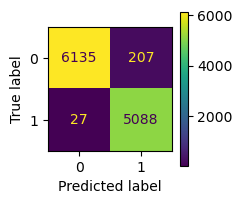

******** Resultados DatasetT1 ********
Accuracy: 97.40944400803002
Precision: 79.78012802671863
Recall: 99.46217904233171
F1-Score: 88.54054054054055
[[50068  1453]
 [   31  5733]]


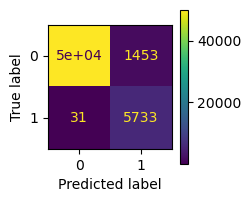

******** Resultados DatasetT2 ********
Accuracy: 97.41817229641268
Precision: 79.8273701795907
Recall: 99.4795281054823
F1-Score: 88.57650420946938
[[50072  1449]
 [   30  5734]]


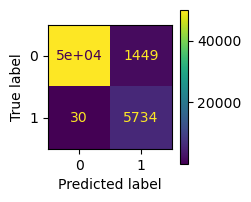

******** Resultados DatasetT3 ********
Accuracy: 97.40420703500044
Precision: 79.71376962623316
Recall: 99.53157529493407
F1-Score: 88.52711982100146
[[50061  1460]
 [   27  5737]]


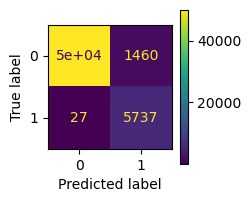

(0.9740420703500043, 0.7971376962623316, 0.9953157529493407)

In [12]:
#final_decision_tree_4 = dtTries.best_estimator_

final_decision_tree_4 = DecisionTreeClassifier(criterion = 'gini', 
                                            max_depth = 6, 
                                            max_features = None, 
                                            max_leaf_nodes = 480, 
                                            min_samples_leaf = 2, 
                                            min_samples_split = 8,
                                            min_weight_fraction_leaf = 0, 
                                            splitter = 'best')


# Holdout test
inputsTrain, inputsTest, outputsTrain, outputsTest = train_test_split(pp_data_inputs, 
                                                                      pp_data_outputs,
                                                                      test_size = 0.2) # 20% dos dados para teste, com 50% das saídas sendo 0

final_decision_tree_4.fit(inputsTrain, outputsTrain)

# Valores preditos pela árvore treinada
predicted_apply_brakes = final_decision_tree_4.predict(inputsTest)

# Métricas de performance
finalAccuracy = accuracy_score(outputsTest, predicted_apply_brakes)
finalPrecision = precision_score(outputsTest, predicted_apply_brakes)
finalRecall = recall_score(outputsTest, predicted_apply_brakes)
finalF1 = f1_score(outputsTest, predicted_apply_brakes)
finalConfusionMatrix = confusion_matrix(outputsTest, predicted_apply_brakes)

plt.rcParams['figure.figsize'] = [2, 2]
plt.rcParams['figure.dpi'] = 100

# Imprime resultados finais
print('Accuracy:', finalAccuracy*100)
print('Precision:', finalPrecision*100)
print('Recall:', finalRecall*100)
print('F1-Score:', finalF1*100)
print(finalConfusionMatrix)
ConfusionMatrixDisplay(finalConfusionMatrix).plot()
plt.show()

#plot_tree(final_decision_tree_4)
#plt.show()  

automatic_test(1, final_decision_tree_4)
automatic_test(2, final_decision_tree_4)
automatic_test(3, final_decision_tree_4)

<h1>decision_tree_5</h1>

In [13]:
pp_dataset = pre_processing("./Datasets/DatasetT&V.csv")

pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
display(pp_data_inputs)

pp_data_outputs = pp_dataset[['Decisão']]
display(pp_data_outputs)


,Distância Ruidosa,Velocidade Ruidosa,Capacidade de Frenagem Ruidosa
0,0.000000,0.000000,1.3950
1,0.000000,0.000000,1.1625
2,1.579846,0.000000,0.9300
3,0.282185,0.000000,0.7800
4,0.394876,0.000000,0.6500
...,...,...,...
57280,2000.433820,26.977928,1.3950
57281,1999.988138,28.886308,1.1625
57282,1998.246886,28.409583,0.9300
57283,2002.044078,27.358991,0.7800


,Decisão
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
57280,0.0
57281,0.0
57282,0.0
57283,0.0


In [ ]:
random_state = 3

# Definição dos hiperparâmetros

criterion = ['entropy', 'gini']

splitter = ['best', 'random']

max_depth = [int(x) for x in np.arange(9, 15, step = 2)] # max_depth já foi limitado

min_samples_split = [int(x) for x in np.arange(2, 18, step = 3)]

min_samples_leaf = [int(x) for x in np.arange(1, 18, step = 3)]

min_weight_fraction_leaf = [float(x) for x in np.linspace(0,0.5,5)] # Ajustado o intervalo, o peso máximo aceito é 0.5, entretanto todas as RSearch dão 0

max_leaf_nodes = [int(x) for x in np.arange(200, 510, step = 10)]
max_leaf_nodes.append(None)

max_features = [int(x) for x in np.arange(1, 4, step = 1)] 
max_features.append('log2')
max_features.append('sqrt')
max_features.append(None)

combinations = len(criterion)*len(splitter)*len(max_depth)*len(min_samples_leaf)*len(min_samples_split)*len(min_weight_fraction_leaf)*len(max_leaf_nodes)*len(max_features)

print('Número de combinações possíveis:', combinations)

hyperparameters_settings = {'criterion'                : criterion,
                            'splitter'                 : splitter,
                            'max_depth'                : max_depth,
                            'min_samples_split'        : min_samples_split,
                            'min_samples_leaf'         : min_samples_leaf,
                            'min_weight_fraction_leaf' : min_weight_fraction_leaf,
                            'max_leaf_nodes'           : max_leaf_nodes,
                            'max_features'             : max_features
                           }

print(hyperparameters_settings)

# Metrica de performance
scoring = 'recall'

# Número de partições
k_fold = 10 

# Número de iterações
n_iter = 2500

print('Tempo estimado de processamento:', round((n_iter*10)/140,1), 'segundos')

In [ ]:
# Criação da árvore de decisão
starting_decision_tree = DecisionTreeClassifier()

# Optimização dos hiperparâmetros com RandomSearch
dtTries = RandomizedSearchCV(estimator = starting_decision_tree, param_distributions = hyperparameters_settings, scoring = scoring,
                            cv = KFold(n_splits = k_fold, shuffle = True), verbose = 3, n_jobs = -1, n_iter = n_iter)

# Teste com os hiperparâmetros encontrados
dtTries.fit(pp_data_inputs, pp_data_outputs)

In [ ]:
# Imprime valores ótimos dos hiperparâmetros
print(dtTries.best_params_)
print(k_fold,'- Fold Best recall-score: ', dtTries.best_score_*100)

In [ ]:
random_state = 1

# Definição dos hiperparâmetros

criterion = ['entropy']

splitter = ['best']

max_depth = [int(x) for x in np.arange(9, 15, step = 1)] # max_depth já foi limitado

min_samples_split = [int(x) for x in np.arange(2, 9, step = 1)]

min_samples_leaf = [int(x) for x in np.arange(1, 4, step = 1)]

min_weight_fraction_leaf = [0] # Ajustado o intervalo, o peso máximo aceito é 0.5, entretanto todas as RSearch dão 0

max_leaf_nodes = [int(x) for x in np.arange(390, 480, step = 10)]

max_features = [int(x) for x in np.arange(1, 4, step = 1)] 

combinations = len(criterion)*len(splitter)*len(max_depth)*len(min_samples_leaf)*len(min_samples_split)*len(min_weight_fraction_leaf)*len(max_leaf_nodes)*len(max_features)

print('Número de combinações possíveis:', combinations)

hyperparameters_settings = {'criterion'                : criterion,
                            'splitter'                 : splitter,
                            'max_depth'                : max_depth,
                            'min_samples_split'        : min_samples_split,
                            'min_samples_leaf'         : min_samples_leaf,
                            'min_weight_fraction_leaf' : min_weight_fraction_leaf,
                            'max_leaf_nodes'           : max_leaf_nodes,
                            'max_features'             : max_features
                           }

print(hyperparameters_settings)

# Metrica de performance
scoring = 'recall'

# Número de partições
k_fold = 10 

# Número de iterações
n_iter = 2500

print('Tempo estimado de processamento:', round((n_iter*10)/140,1), 'segundos')

In [ ]:
# Criação da árvore de decisão
starting_decision_tree = DecisionTreeClassifier()

# Optimização dos hiperparâmetros com GridSearch
dtTries = GridSearchCV(estimator = starting_decision_tree, param_grid = hyperparameters_settings, scoring = scoring,
                            cv = KFold(n_splits = k_fold, shuffle = True), verbose = 3, n_jobs = -1)

# Teste com os hiperparâmetros encontrados
dtTries.fit(pp_data_inputs, pp_data_outputs)

In [ ]:
# Imprime valores ótimos dos hiperparâmetros
print(dtTries.best_params_)
print(k_fold,'- Fold Best recall-score: ', dtTries.best_score_*100)

<h2>final_decision_tree_5</h2>

Accuracy: 99.38029152483197
Precision: 96.51474530831099
Recall: 97.12230215827337
F1-Score: 96.81757059614523
[[10306    39]
 [   32  1080]]


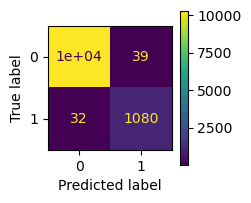

******** Resultados DatasetT1 ********
Accuracy: 99.3052282447412
Precision: 96.85644428920712
Recall: 96.21790423317141
F1-Score: 96.53611836379461
[[51341   180]
 [  218  5546]]


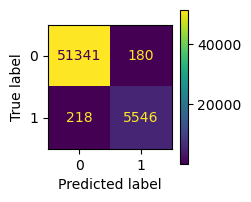

******** Resultados DatasetT2 ********
Accuracy: 99.25285851444532
Precision: 96.44846796657382
Recall: 96.11380985426787
F1-Score: 96.28084810566563
[[51317   204]
 [  224  5540]]


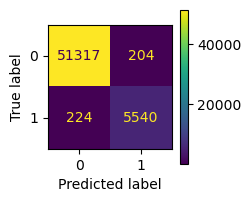

******** Resultados DatasetT3 ********
Accuracy: 99.27904337959326
Precision: 96.57093124456048
Recall: 96.25260235947259
F1-Score: 96.41150404031627
[[51324   197]
 [  216  5548]]


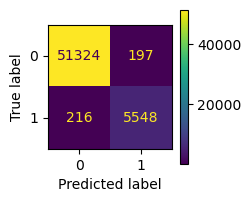

(0.9927904337959326, 0.9657093124456049, 0.9625260235947258)

In [14]:
#final_decision_tree_5 = dtTries.best_estimator_

final_decision_tree_5 = DecisionTreeClassifier(criterion = 'entropy', 
                                            max_depth = 13, 
                                            max_features = 2, 
                                            max_leaf_nodes = 470, 
                                            min_samples_leaf = 3, 
                                            min_samples_split = 4,
                                            min_weight_fraction_leaf = 0, 
                                            splitter = 'best')


# Holdout test
inputsTrain, inputsTest, outputsTrain, outputsTest = train_test_split(pp_data_inputs, 
                                                                      pp_data_outputs,
                                                                      test_size = 0.2) # 20% dos dados para teste, com 50% das saídas sendo 0

final_decision_tree_5.fit(inputsTrain, outputsTrain)

# Valores preditos pela árvore treinada
predicted_apply_brakes = final_decision_tree_5.predict(inputsTest)

# Métricas de performance
finalAccuracy = accuracy_score(outputsTest, predicted_apply_brakes)
finalPrecision = precision_score(outputsTest, predicted_apply_brakes)
finalRecall = recall_score(outputsTest, predicted_apply_brakes)
finalF1 = f1_score(outputsTest, predicted_apply_brakes)
finalConfusionMatrix = confusion_matrix(outputsTest, predicted_apply_brakes)

# Imprime resultados finais
print('Accuracy:', finalAccuracy*100)
print('Precision:', finalPrecision*100)
print('Recall:', finalRecall*100)
print('F1-Score:', finalF1*100)
print(finalConfusionMatrix)
ConfusionMatrixDisplay(finalConfusionMatrix).plot()
plt.show()

plt.rcParams['figure.figsize'] = [2, 2]
plt.rcParams['figure.dpi'] = 100

automatic_test(1, final_decision_tree_5)
automatic_test(2, final_decision_tree_5)
automatic_test(3, final_decision_tree_5)

<h1>decision_tree_6</h1>

In [15]:
pp_dataset = pre_processing("./Datasets/DatasetT&V2.csv")

pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
display(pp_data_inputs)

pp_data_outputs = pp_dataset[['Decisão']]
display(pp_data_outputs)

,Distância Ruidosa,Velocidade Ruidosa,Capacidade de Frenagem Ruidosa
0,1.426390,0.000000,1.3950
1,0.247126,0.000000,1.1625
2,1.318730,0.000000,0.9300
3,0.000000,0.000000,0.7800
4,1.181601,0.000000,0.6500
...,...,...,...
57280,1998.258208,27.787054,1.3950
57281,2001.582818,27.545077,1.1625
57282,2000.103125,29.680000,0.9300
57283,2001.308140,28.895288,0.7800


,Decisão
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
57280,0.0
57281,0.0
57282,0.0
57283,0.0


In [ ]:
random_state = None
# Definição dos hiperparâmetros

criterion = ['entropy', 'gini']

splitter = ['best', 'random']

max_depth = [int(x) for x in np.arange(5, 10, step = 1)] # Limite para compilação

min_samples_split = [int(x) for x in np.arange(2, 18, step = 3)]

min_samples_leaf = [int(x) for x in np.arange(1, 18, step = 3)]

max_leaf_nodes = [int(x) for x in np.arange(200, 510, step = 10)]
max_leaf_nodes.append(None)

max_features = [int(x) for x in np.arange(1, 4, step = 1)] 
max_features.append('log2')
max_features.append('sqrt')
max_features.append(None)

combinations = len(criterion)*len(splitter)*len(max_depth)*len(min_samples_leaf)*len(min_samples_split)*len(max_leaf_nodes)*len(max_features)

print('Número de combinações possíveis:', combinations)

hyperparameters_settings = {'criterion'                : criterion,
                            'splitter'                 : splitter,
                            'max_depth'                : max_depth,
                            'min_samples_split'        : min_samples_split,
                            'min_samples_leaf'         : min_samples_leaf,
                            'max_leaf_nodes'           : max_leaf_nodes,
                            'max_features'             : max_features
                           }

print(hyperparameters_settings)

# Metrica de performance
scoring = 'recall'

# Número de partições
k_fold = 10 

# Número de iterações
n_iter = 2500

print('Tempo estimado de processamento:', round((n_iter*10)/140,1), 'segundos')



In [ ]:
# Criação da árvore de decisão
starting_decision_tree = DecisionTreeClassifier()

# Optimização dos hiperparâmetros com RandomSearch
dtTries = RandomizedSearchCV(estimator = starting_decision_tree, param_distributions = hyperparameters_settings, scoring = scoring,
                            cv = KFold(n_splits = k_fold, shuffle = True), verbose = 3, n_jobs = -1, n_iter = n_iter)

# Teste com os hiperparâmetros encontrados
dtTries.fit(pp_data_inputs, pp_data_outputs)

In [ ]:

# Imprime valores ótimos dos hiperparâmetros
print(dtTries.best_params_)
print(k_fold,'- Fold Best recall-score: ', dtTries.best_score_*100)

In [ ]:
random_state = 1

# Definição dos hiperparâmetros

criterion = ['gini']

splitter = ['best']

max_depth = [int(x) for x in np.arange(7, 12, step = 1)] # max_depth já foi limitado

min_samples_split = [int(x) for x in np.arange(6, 12, step = 1)]

min_samples_leaf = [int(x) for x in np.arange(1, 4, step = 1)]

min_weight_fraction_leaf = [0] # Ajustado o intervalo, o peso máximo aceito é 0.5, entretanto todas as RSearch dão 0

max_leaf_nodes = [int(x) for x in np.arange(380, 460, step = 10)]

max_features = [int(x) for x in np.arange(1, 4, step = 1)] 

combinations = len(criterion)*len(splitter)*len(max_depth)*len(min_samples_leaf)*len(min_samples_split)*len(min_weight_fraction_leaf)*len(max_leaf_nodes)*len(max_features)

print('Número de combinações possíveis:', combinations)

hyperparameters_settings = {'criterion'                : criterion,
                            'splitter'                 : splitter,
                            'max_depth'                : max_depth,
                            'min_samples_split'        : min_samples_split,
                            'min_samples_leaf'         : min_samples_leaf,
                            'min_weight_fraction_leaf' : min_weight_fraction_leaf,
                            'max_leaf_nodes'           : max_leaf_nodes,
                            'max_features'             : max_features
                           }

print(hyperparameters_settings)

# Metrica de performance
scoring = 'recall'

# Número de partições
k_fold = 10 

# Número de iterações
n_iter = 2500

print('Tempo estimado de processamento:', round((n_iter*10)/140,1), 'segundos')

In [ ]:

# Criação da árvore de decisão
starting_decision_tree = DecisionTreeClassifier()

# Optimização dos hiperparâmetros com GridSearch
dtTries = GridSearchCV(estimator = starting_decision_tree, param_grid = hyperparameters_settings, scoring = scoring,
                            cv = KFold(n_splits = k_fold, shuffle = True), verbose = 3, n_jobs = -1)

# Teste com os hiperparâmetros encontrados
dtTries.fit(pp_data_inputs, pp_data_outputs)

In [ ]:
# Imprime valores ótimos dos hiperparâmetros
print(dtTries.best_params_)
print(k_fold,'- Fold Best recall-score: ', dtTries.best_score_*100)

<h2>final_decision_tree_6</h2>

Accuracy: 99.14462773850047
Precision: 95.74468085106383
Recall: 95.9079283887468
F1-Score: 95.82623509369678
[[10234    50]
 [   48  1125]]


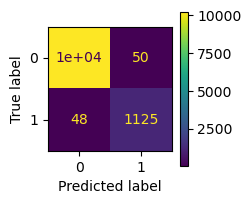

******** Resultados DatasetT1 ********
Accuracy: 99.37680020947892
Precision: 97.12393236883389
Recall: 96.66897987508675
F1-Score: 96.89592209373099
[[51356   165]
 [  192  5572]]


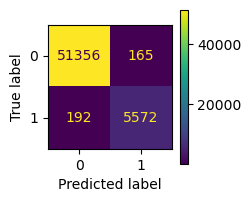

******** Resultados DatasetT2 ********
Accuracy: 99.35236100200751
Precision: 96.85490877497827
Recall: 96.70367800138793
F1-Score: 96.77923430853373
[[51340   181]
 [  190  5574]]


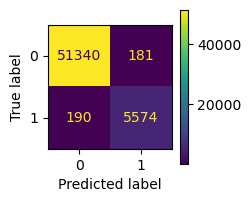

******** Resultados DatasetT3 ********
Accuracy: 99.37505455180239
Precision: 97.0414201183432
Recall: 96.73837612768911
F1-Score: 96.88966116420504
[[51351   170]
 [  188  5576]]


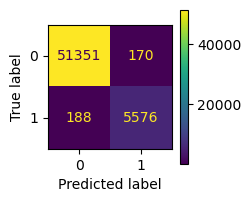

(0.9937505455180239, 0.9704142011834319, 0.9673837612768911)

In [16]:
#final_decision_tree_6 = dtTries.best_estimator_

final_decision_tree_6 = DecisionTreeClassifier(criterion = 'gini', 
                                            max_depth = 9, 
                                            max_features = 3, 
                                            max_leaf_nodes = 410, 
                                            min_samples_leaf = 3, 
                                            min_samples_split = 6,
                                            min_weight_fraction_leaf = 0, 
                                            splitter = 'best')


# Holdout test
inputsTrain, inputsTest, outputsTrain, outputsTest = train_test_split(pp_data_inputs, 
                                                                      pp_data_outputs,
                                                                      test_size = 0.2)

final_decision_tree_6.fit(inputsTrain, outputsTrain)

# Valores preditos pela árvore treinada
predicted_apply_brakes = final_decision_tree_6.predict(inputsTest)

# Métricas de performance
finalAccuracy = accuracy_score(outputsTest, predicted_apply_brakes)
finalPrecision = precision_score(outputsTest, predicted_apply_brakes)
finalRecall = recall_score(outputsTest, predicted_apply_brakes)
finalF1 = f1_score(outputsTest, predicted_apply_brakes)
finalConfusionMatrix = confusion_matrix(outputsTest, predicted_apply_brakes)

# Imprime resultados finais
print('Accuracy:', finalAccuracy*100)
print('Precision:', finalPrecision*100)
print('Recall:', finalRecall*100)
print('F1-Score:', finalF1*100)
print(finalConfusionMatrix)
ConfusionMatrixDisplay(finalConfusionMatrix).plot()
plt.show()

plt.rcParams['figure.figsize'] = [2, 2]
plt.rcParams['figure.dpi'] = 100

automatic_test(1, final_decision_tree_6)
automatic_test(2, final_decision_tree_6)
automatic_test(3, final_decision_tree_6)

<h1>decision_tree_7</h1>

In [17]:
pp_dataset = pre_processing("./Datasets/DatasetStratified80v2.csv")

pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
display(pp_data_inputs)

pp_data_outputs = pp_dataset[['Decisão']]
display(pp_data_outputs)

,Distância Ruidosa,Velocidade Ruidosa,Capacidade de Frenagem Ruidosa
0,1988.706008,27.661945,1.1625
1,1951.376805,28.481030,1.3950
2,902.057984,14.818392,0.6500
3,471.638365,15.694182,1.3950
4,1960.458622,5.904616,0.9300
...,...,...,...
57280,477.714702,16.595143,0.6500
57281,191.283960,15.690130,0.7800
57282,179.876135,11.504720,1.1625
57283,790.979597,0.514615,0.9300


,Decisão
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
57280,0.0
57281,1.0
57282,0.0
57283,0.0


In [ ]:
random_state = None

# Definição dos hiperparâmetros

criterion = ['entropy', 'gini']

splitter = ['best', 'random']

max_depth = [int(x) for x in np.arange(5, 11, step = 1)] # max_depth já foi limitado

min_samples_split = [int(x) for x in np.arange(2, 18, step = 3)]

min_samples_leaf = [int(x) for x in np.arange(1, 18, step = 3)]

min_weight_fraction_leaf = [0] # Ajustado o intervalo, o peso máximo aceito é 0.5, entretanto todas as RSearch dão 0

max_leaf_nodes = [int(x) for x in np.arange(200, 510, step = 10)]
max_leaf_nodes.append(None)

max_features = [int(x) for x in np.arange(1, 4, step = 1)] 
max_features.append('log2')
max_features.append('sqrt')
max_features.append(None)

combinations = len(criterion)*len(splitter)*len(max_depth)*len(min_samples_leaf)*len(min_samples_split)*len(min_weight_fraction_leaf)*len(max_leaf_nodes)*len(max_features)

print('Número de combinações possíveis:', combinations)

hyperparameters_settings = {'criterion'                : criterion,
                            'splitter'                 : splitter,
                            'max_depth'                : max_depth,
                            'min_samples_split'        : min_samples_split,
                            'min_samples_leaf'         : min_samples_leaf,
                            'min_weight_fraction_leaf' : min_weight_fraction_leaf,
                            'max_leaf_nodes'           : max_leaf_nodes,
                            'max_features'             : max_features
                           }

print(hyperparameters_settings)

# Metrica de performance
scoring = 'recall'

# Número de partições
k_fold = 10 

# Número de iterações
n_iter = 2500

print('Tempo estimado de processamento:', round((n_iter*10)/140,1), 'segundos')


In [ ]:
# Criação da árvore de decisão
starting_decision_tree = DecisionTreeClassifier()

# Optimização dos hiperparâmetros com RandomSearch
dtTries = RandomizedSearchCV(estimator = starting_decision_tree, param_distributions = hyperparameters_settings, scoring = scoring,
                            cv = KFold(n_splits = k_fold, shuffle = True), verbose = 3, n_jobs = -1, n_iter = n_iter)

# Teste com os hiperparâmetros encontrados
dtTries.fit(pp_data_inputs, pp_data_outputs)


In [ ]:
# Imprime valores ótimos dos hiperparâmetros
print(dtTries.best_params_)
print(k_fold,'- Fold Best recall-score: ', dtTries.best_score_*100)

In [ ]:
random_state = 1

# Definição dos hiperparâmetros

criterion = ['gini']

splitter = ['best']

max_depth = [int(x) for x in np.arange(7, 11, step = 1)] # max_depth já foi limitado

min_samples_split = [int(x) for x in np.arange(2, 5, step = 1)]
min_samples_split.append(float(1))

min_samples_leaf = [int(x) for x in np.arange(1, 4, step = 1)]

min_weight_fraction_leaf = [0] # Ajustado o intervalo, o peso máximo aceito é 0.5, entretanto todas as RSearch dão 0

max_leaf_nodes = [int(x) for x in np.arange(370, 440, step = 10)]

max_features = [int(x) for x in np.arange(1, 4, step = 1)] 

combinations = len(criterion)*len(splitter)*len(max_depth)*len(min_samples_leaf)*len(min_samples_split)*len(min_weight_fraction_leaf)*len(max_leaf_nodes)*len(max_features)

print('Número de combinações possíveis:', combinations)

hyperparameters_settings = {'criterion'                : criterion,
                            'splitter'                 : splitter,
                            'max_depth'                : max_depth,
                            'min_samples_split'        : min_samples_split,
                            'min_samples_leaf'         : min_samples_leaf,
                            'min_weight_fraction_leaf' : min_weight_fraction_leaf,
                            'max_leaf_nodes'           : max_leaf_nodes,
                            'max_features'             : max_features
                           }

print(hyperparameters_settings)

# Metrica de performance
scoring = 'recall'

# Número de partições
k_fold = 10 

# Número de iterações
n_iter = 2500

print('Tempo estimado de processamento:', round((n_iter*10)/140,1), 'segundos')


In [ ]:
# Criação da árvore de decisão
starting_decision_tree = DecisionTreeClassifier()

# Optimização dos hiperparâmetros com GridSearch
dtTries = GridSearchCV(estimator = starting_decision_tree, param_grid = hyperparameters_settings, scoring = scoring,
                            cv = KFold(n_splits = k_fold, shuffle = True), verbose = 3, n_jobs = -1)

# Teste com os hiperparâmetros encontrados
dtTries.fit(pp_data_inputs, pp_data_outputs)


In [ ]:
# Imprime valores ótimos dos hiperparâmetros
print(dtTries.best_params_)
print(k_fold,'- Fold Best recall-score: ', dtTries.best_score_*100)

<h2>final_decision_tree_7</h2>

Accuracy: 99.10098629658724
Precision: 97.42820402914703
Recall: 98.1433506044905
F1-Score: 97.78446977844698
[[9081   60]
 [  43 2273]]


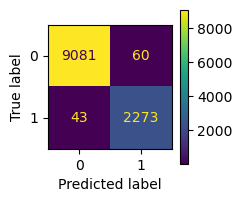

******** Resultados DatasetT1 ********
Accuracy: 99.25984114515144
Precision: 94.5
Recall: 98.36918806384455
F1-Score: 96.39578374702481
[[51191   330]
 [   94  5670]]


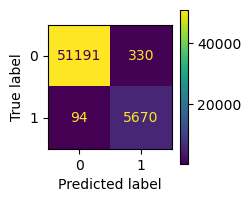

******** Resultados DatasetT2 ********
Accuracy: 99.16732128829537
Precision: 93.83186867849444
Recall: 98.17834836918806
F1-Score: 95.9559135226791
[[51149   372]
 [  105  5659]]


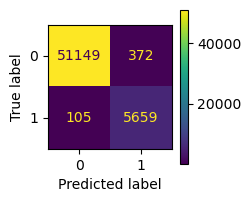

******** Resultados DatasetT3 ********
Accuracy: 99.23889325303308
Precision: 94.22310756972112
Recall: 98.47328244274809
F1-Score: 96.30132337970818
[[51173   348]
 [   88  5676]]


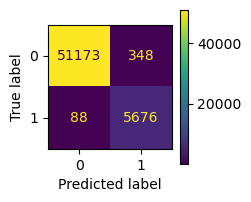

(0.9923889325303308, 0.9422310756972112, 0.9847328244274809)

In [18]:
#final_decision_tree_7 = dtTries.best_estimator_

final_decision_tree_7 = DecisionTreeClassifier(criterion = 'gini', 
                                            max_depth = 9, 
                                            max_features = 3, 
                                            max_leaf_nodes = 370, 
                                            min_samples_leaf = 3, 
                                            min_samples_split = 4,
                                            min_weight_fraction_leaf = 0, 
                                            splitter = 'best')


# Holdout test
inputsTrain, inputsTest, outputsTrain, outputsTest = train_test_split(pp_data_inputs, 
                                                                      pp_data_outputs,
                                                                      test_size = 0.2) # 20% dos dados para teste, com 50% das saídas sendo 0

final_decision_tree_7.fit(inputsTrain, outputsTrain)

# Valores preditos pela árvore treinada
predicted_apply_brakes = final_decision_tree_7.predict(inputsTest)

# Métricas de performance
finalAccuracy = accuracy_score(outputsTest, predicted_apply_brakes)
finalPrecision = precision_score(outputsTest, predicted_apply_brakes)
finalRecall = recall_score(outputsTest, predicted_apply_brakes)
finalF1 = f1_score(outputsTest, predicted_apply_brakes)
finalConfusionMatrix = confusion_matrix(outputsTest, predicted_apply_brakes)

# Imprime resultados finais
print('Accuracy:', finalAccuracy*100)
print('Precision:', finalPrecision*100)
print('Recall:', finalRecall*100)
print('F1-Score:', finalF1*100)
print(finalConfusionMatrix)
ConfusionMatrixDisplay(finalConfusionMatrix).plot()
plt.show()

plt.rcParams['figure.figsize'] = [2, 2]
plt.rcParams['figure.dpi'] = 100

automatic_test(1, final_decision_tree_7)
automatic_test(2, final_decision_tree_7)
automatic_test(3, final_decision_tree_7)

<h1>decision_tree_8</h1>

In [19]:
pp_dataset = pre_processing("./Datasets/DatasetStratified50.csv")

pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
display(pp_data_inputs)

pp_data_outputs = pp_dataset[['Decisão']]
display(pp_data_outputs)

,Distância Ruidosa,Velocidade Ruidosa,Capacidade de Frenagem Ruidosa
0,20.541409,4.403611,1.3950
1,0.000000,1.503059,1.1625
2,8.315942,11.130000,1.3950
3,229.223089,26.364614,1.3950
4,301.600644,27.019522,1.1625
...,...,...,...
57280,128.902174,22.820830,1.3950
57281,129.577958,26.238299,0.9300
57282,51.278493,11.479303,0.6500
57283,728.433355,10.928530,0.9300


,Decisão
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
57280,1.0
57281,1.0
57282,1.0
57283,0.0


In [ ]:
random_state = None

# Definição dos hiperparâmetros

criterion = ['entropy', 'gini']

splitter = ['best', 'random']

max_depth = [int(x) for x in np.arange(5, 11, step = 1)] # max_depth já foi limitado

min_samples_split = [int(x) for x in np.arange(2, 18, step = 3)]

min_samples_leaf = [int(x) for x in np.arange(1, 18, step = 3)]

min_weight_fraction_leaf = [0] # Ajustado o intervalo, o peso máximo aceito é 0.5, entretanto todas as RSearch dão 0

max_leaf_nodes = [int(x) for x in np.arange(200, 510, step = 10)]
max_leaf_nodes.append(None)

max_features = [int(x) for x in np.arange(1, 4, step = 1)] 
max_features.append('log2')
max_features.append('sqrt')
max_features.append(None)

combinations = len(criterion)*len(splitter)*len(max_depth)*len(min_samples_leaf)*len(min_samples_split)*len(min_weight_fraction_leaf)*len(max_leaf_nodes)*len(max_features)

print('Número de combinações possíveis:', combinations)

hyperparameters_settings = {'criterion'                : criterion,
                            'splitter'                 : splitter,
                            'max_depth'                : max_depth,
                            'min_samples_split'        : min_samples_split,
                            'min_samples_leaf'         : min_samples_leaf,
                            'min_weight_fraction_leaf' : min_weight_fraction_leaf,
                            'max_leaf_nodes'           : max_leaf_nodes,
                            'max_features'             : max_features
                           }

print(hyperparameters_settings)

# Metrica de performance
scoring = 'recall'

# Número de partições
k_fold = 10 

# Número de iterações
n_iter = 2500

print('Tempo estimado de processamento:', round((n_iter*10)/140,1), 'segundos')


In [ ]:
# Criação da árvore de decisão
starting_decision_tree = DecisionTreeClassifier()

# Optimização dos hiperparâmetros com RandomSearch
dtTries = RandomizedSearchCV(estimator = starting_decision_tree, param_distributions = hyperparameters_settings, scoring = scoring,
                            cv = KFold(n_splits = k_fold, shuffle = True), verbose = 3, n_jobs = -1, n_iter = n_iter)

# Teste com os hiperparâmetros encontrados
dtTries.fit(pp_data_inputs, pp_data_outputs)


In [ ]:
# Imprime valores ótimos dos hiperparâmetros
print(dtTries.best_params_)
print(k_fold,'- Fold Best recall-score: ', dtTries.best_score_*100)


In [ ]:
random_state = 1

# Definição dos hiperparâmetros

criterion = ['entropy']

splitter = ['best']

max_depth = [int(x) for x in np.arange(3, 9, step = 1)] # max_depth já foi limitado

min_samples_split = [int(x) for x in np.arange(2, 5, step = 1)]

min_samples_leaf = [int(x) for x in np.arange(5, 10, step = 1)]

min_weight_fraction_leaf = [0] # Ajustado o intervalo, o peso máximo aceito é 0.5, entretanto todas as RSearch dão 0

max_leaf_nodes = [int(x) for x in np.arange(250, 320, step = 10)]

max_features = [None] 

combinations = len(criterion)*len(splitter)*len(max_depth)*len(min_samples_leaf)*len(min_samples_split)*len(min_weight_fraction_leaf)*len(max_leaf_nodes)*len(max_features)

print('Número de combinações possíveis:', combinations)

hyperparameters_settings = {'criterion'                : criterion,
                            'splitter'                 : splitter,
                            'max_depth'                : max_depth,
                            'min_samples_split'        : min_samples_split,
                            'min_samples_leaf'         : min_samples_leaf,
                            'min_weight_fraction_leaf' : min_weight_fraction_leaf,
                            'max_leaf_nodes'           : max_leaf_nodes,
                            'max_features'             : max_features
                           }

print(hyperparameters_settings)

# Metrica de performance
scoring = 'recall'

# Número de partições
k_fold = 10 

# Número de iterações
n_iter = 2500

print('Tempo estimado de processamento:', round((n_iter*10)/140,1), 'segundos')


In [ ]:
# Criação da árvore de decisão
starting_decision_tree = DecisionTreeClassifier()

# Optimização dos hiperparâmetros com GridSearch
dtTries = GridSearchCV(estimator = starting_decision_tree, param_grid = hyperparameters_settings, scoring = scoring,
                            cv = KFold(n_splits = k_fold, shuffle = True), verbose = 3, n_jobs = -1)

# Teste com os hiperparâmetros encontrados
dtTries.fit(pp_data_inputs, pp_data_outputs)


In [ ]:
# Imprime valores ótimos dos hiperparâmetros
print(dtTries.best_params_)
print(k_fold,'- Fold Best recall-score: ', dtTries.best_score_*100)


<h2>final_decision_tree_8</h2>

Accuracy: 95.69695382735446
Precision: 92.35379880123116
Recall: 99.63299545613422
F1-Score: 95.85540142917193
[[5263  472]
 [  21 5701]]


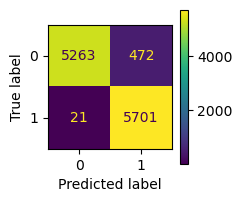

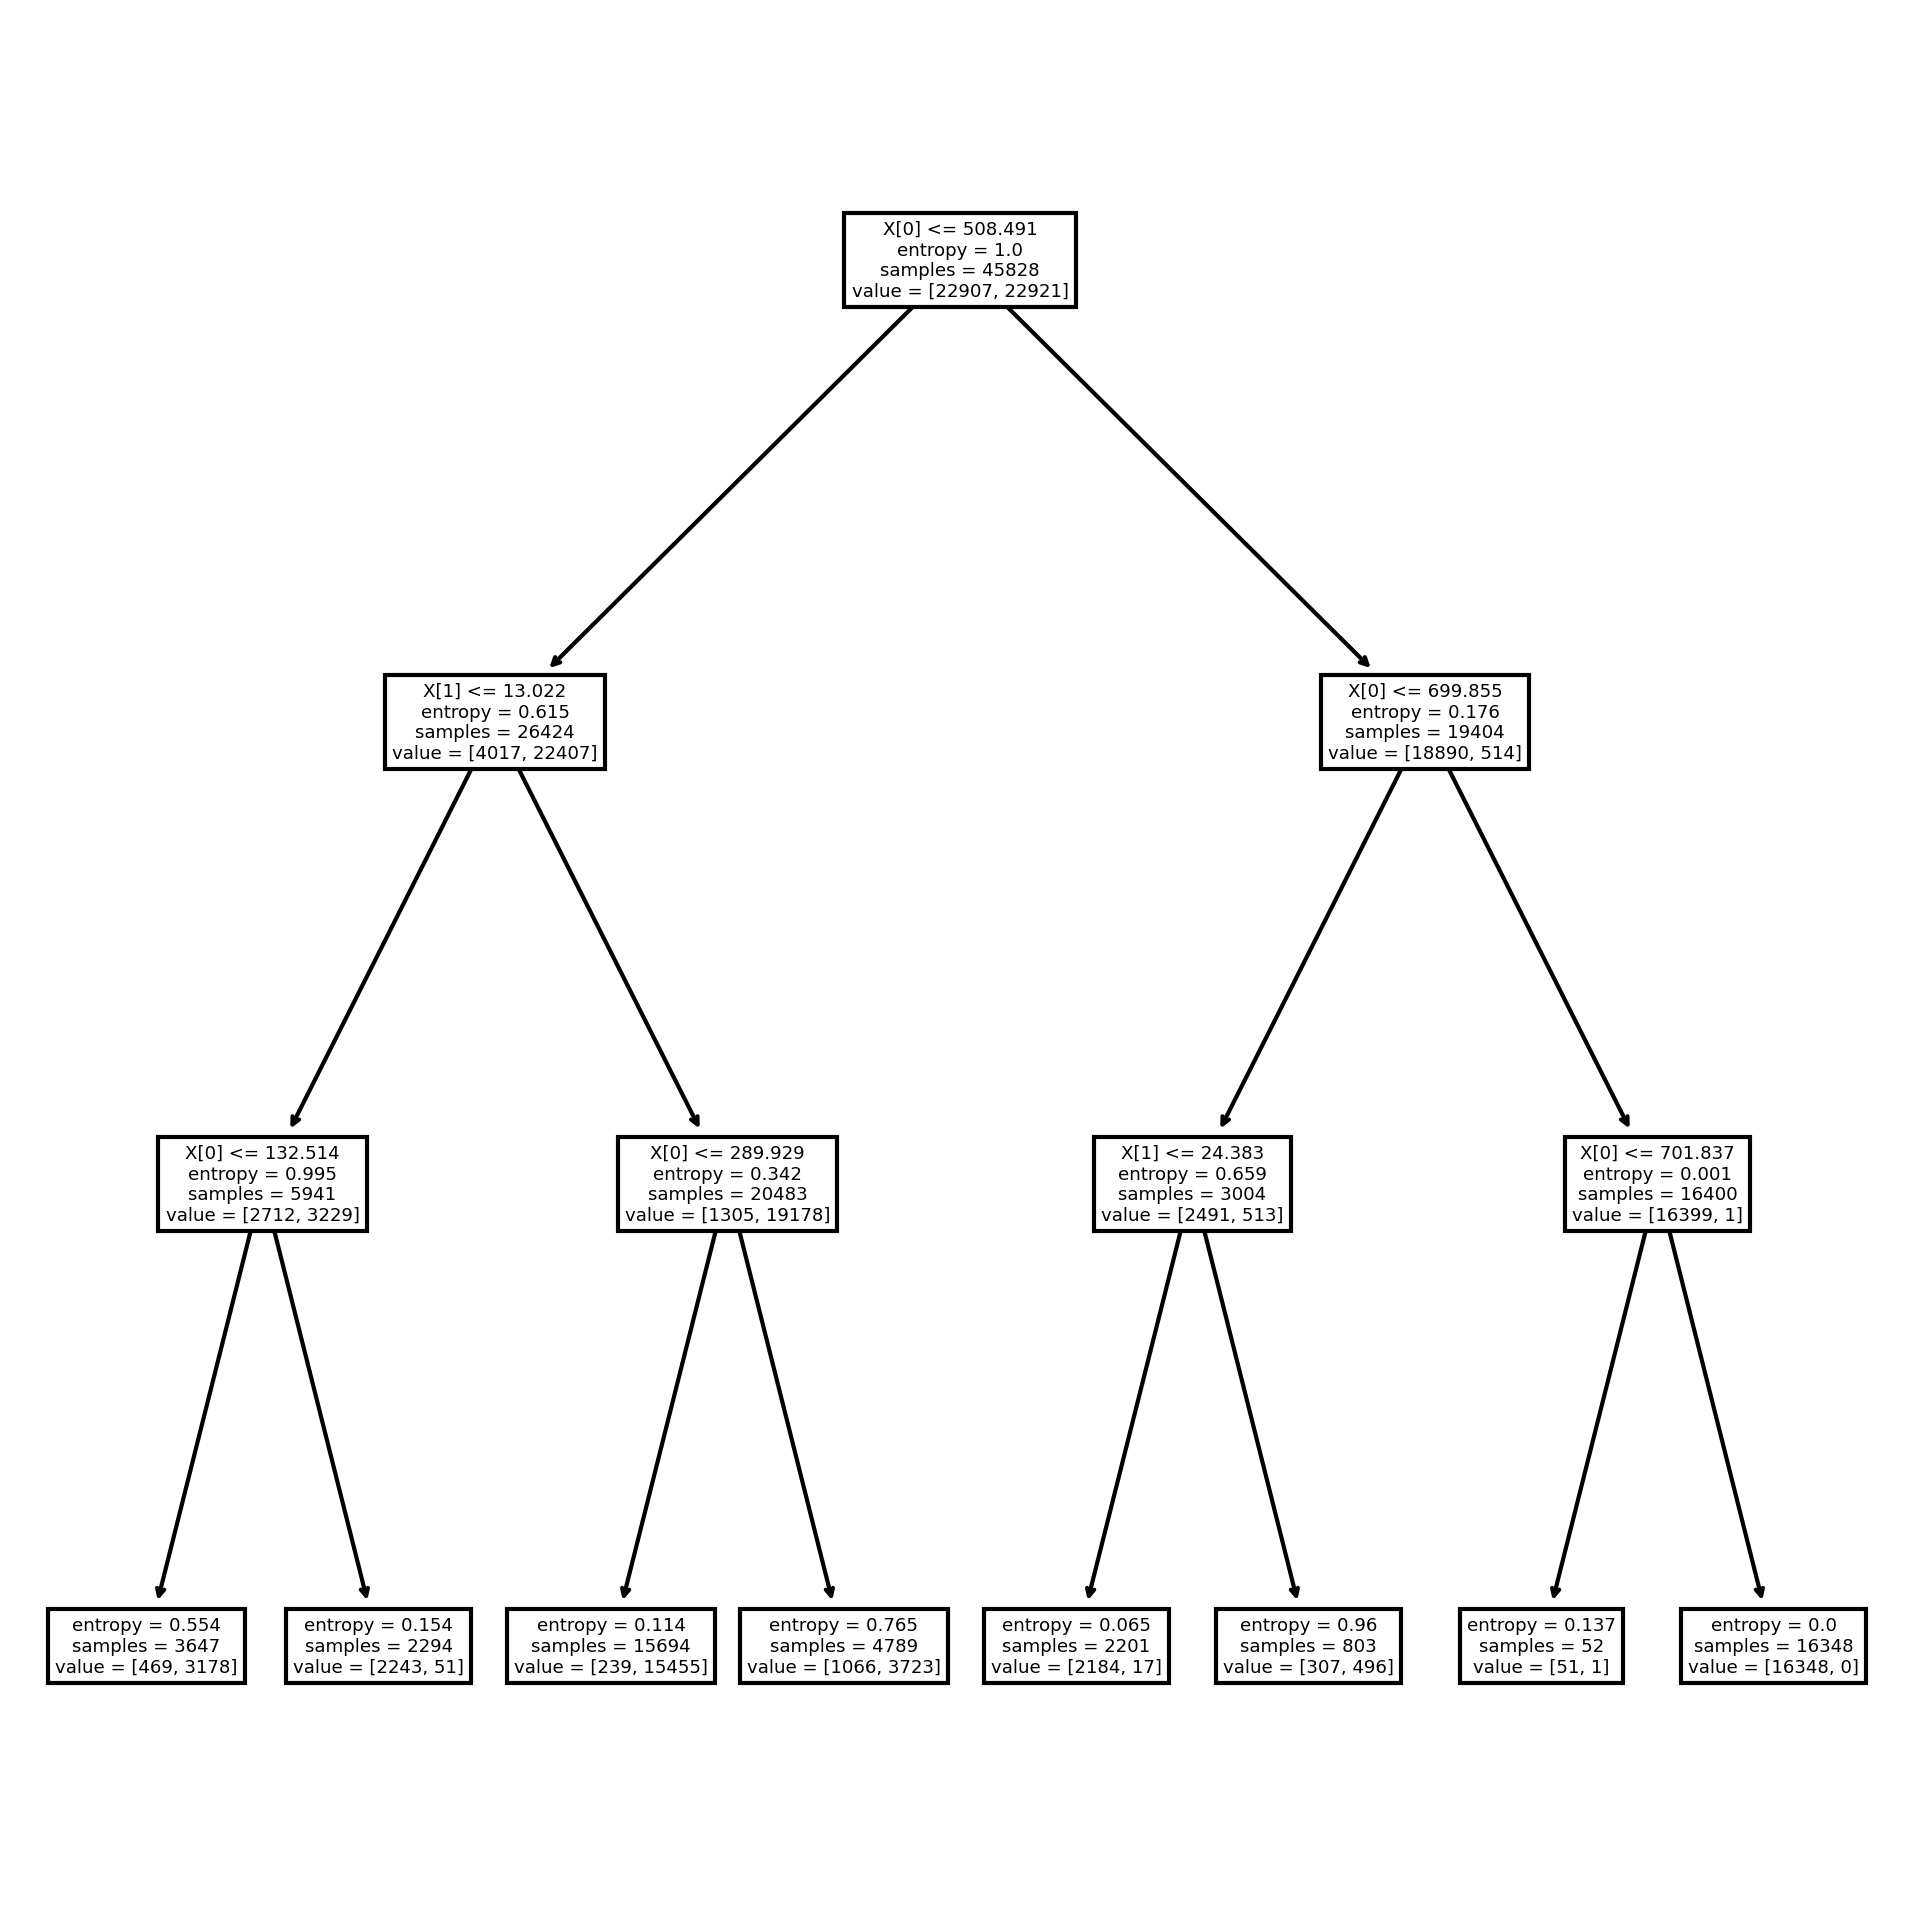

******** Resultados DatasetT1 ********
Accuracy: 91.84603299293008
Precision: 55.258346964302895
Recall: 99.63566967383761
F1-Score: 71.08993006127375
[[46871  4650]
 [   21  5743]]


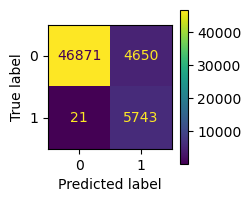

******** Resultados DatasetT2 ********
Accuracy: 91.8530156236362
Precision: 55.27962267783232
Recall: 99.63566967383761
F1-Score: 71.1075342041726
[[46875  4646]
 [   21  5743]]


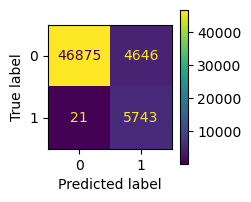

******** Resultados DatasetT3 ********
Accuracy: 91.87570917343109
Precision: 55.34991324465008
Recall: 99.61832061068702
F1-Score: 71.16123435369934
[[46889  4632]
 [   22  5742]]


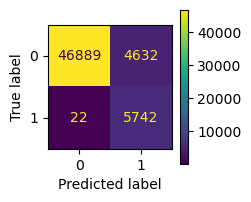

(0.9187570917343109, 0.5534991324465008, 0.9961832061068703)

In [20]:
#final_decision_tree_8 = dtTries.best_estimator_

final_decision_tree_8 = DecisionTreeClassifier(criterion = 'entropy', 
                                            max_depth = 3, 
                                            max_features = None, 
                                            max_leaf_nodes = 250, 
                                            min_samples_leaf = 5, 
                                            min_samples_split = 2,
                                            min_weight_fraction_leaf = 0, 
                                            splitter = 'best')


# Holdout test
inputsTrain, inputsTest, outputsTrain, outputsTest = train_test_split(pp_data_inputs, 
                                                                      pp_data_outputs,
                                                                      test_size = 0.2) # 20% dos dados para teste

final_decision_tree_8.fit(inputsTrain, outputsTrain)

# Valores preditos pela árvore treinada
predicted_apply_brakes = final_decision_tree_8.predict(inputsTest)

# Métricas de performance
finalAccuracy = accuracy_score(outputsTest, predicted_apply_brakes)
finalPrecision = precision_score(outputsTest, predicted_apply_brakes)
finalRecall = recall_score(outputsTest, predicted_apply_brakes)
finalF1 = f1_score(outputsTest, predicted_apply_brakes)
finalConfusionMatrix = confusion_matrix(outputsTest, predicted_apply_brakes)

# Imprime resultados finais
print('Accuracy:', finalAccuracy*100)
print('Precision:', finalPrecision*100)
print('Recall:', finalRecall*100)
print('F1-Score:', finalF1*100)
print(finalConfusionMatrix)

plt.rcParams['figure.figsize'] = [2, 2]
plt.rcParams['figure.dpi'] = 100

ConfusionMatrixDisplay(finalConfusionMatrix).plot()
plt.show()

plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['figure.dpi'] = 300

plot_tree(final_decision_tree_8)
plt.show()  

plt.rcParams['figure.figsize'] = [2, 2]
plt.rcParams['figure.dpi'] = 100

automatic_test(1, final_decision_tree_8)
automatic_test(2, final_decision_tree_8)
automatic_test(3, final_decision_tree_8)

<h1>max_depth results comparison</h1>

In [ ]:
pp_dataset = pre_processing("./Datasets/DatasetT&V.csv")
pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
pp_data_outputs = pp_dataset[['Decisão']]

In [ ]:
ensemble_16 = [final_decision_tree_1, final_decision_tree_3, final_decision_tree_4]
ensemble_13 = [final_decision_tree_5, final_decision_tree_3, final_decision_tree_4]
ensemble_9 = [final_decision_tree_6, final_decision_tree_3, final_decision_tree_4]

rf_16 = RandomForestClassifier(n_estimators=len(ensemble_16)).fit(pp_data_inputs, pp_data_outputs)
rf_13 = RandomForestClassifier(n_estimators=len(ensemble_13)).fit(pp_data_inputs, pp_data_outputs)
rf_9 = RandomForestClassifier(n_estimators=len(ensemble_9)).fit(pp_data_inputs, pp_data_outputs)

rf_16 = convert_tree_to_random_forest(ensemble_16, rf_16)
rf_13 = convert_tree_to_random_forest(ensemble_13, rf_13)
rf_9 = convert_tree_to_random_forest(ensemble_9, rf_9)

In [ ]:
result_16_1 = automatic_test(1, rf_16)
result_13_1 = automatic_test(1, rf_13)
result_9_1 = automatic_test(1, rf_9)

result_16_2 = automatic_test(2, rf_16)
result_13_2 = automatic_test(2, rf_13)
result_9_2 = automatic_test(2, rf_9)

result_16_3 = automatic_test(3, rf_16)
result_13_3 = automatic_test(3, rf_13)
result_9_3 = automatic_test(3, rf_9)

#Grava métricas em um arquivo .txt
import sys

original_stdout = sys.stdout
with open(f"max_depth results comparison (ensemble)", 'w') as f:
    sys.stdout = f
    print(f"Precision T1 max_depth_16: {result_16_1[1]*100}")
    print(f"Precision T1 max_depth_13: {result_13_1[1]*100}")
    print(f"Precision T1 max_depth_9: {result_9_1[1]*100}")
    print("")
    print(f"Recall T1 max_depth_16: {result_16_1[2]*100}")
    print(f"Recall T1 max_depth_13: {result_13_1[2]*100}")
    print(f"Recall T1 max_depth_9: {result_9_1[2]*100}")
    print("*********************************************")
    print(f"Precision T2 max_depth_16: {result_16_2[1]*100}")
    print(f"Precision T2 max_depth_13: {result_13_2[1]*100}")
    print(f"Precision T2 max_depth_9: {result_9_2[1]*100}")
    print("")
    print(f"Recall T2 max_depth_16: {result_16_2[2]*100}")
    print(f"Recall T2 max_depth_13: {result_13_2[2]*100}")
    print(f"Recall T2 max_depth_9: {result_9_2[2]*100}")
    print("*********************************************")
    print(f"Precision T3 max_depth_16: {result_16_3[1]*100}")
    print(f"Precision T3 max_depth_13: {result_13_3[1]*100}")
    print(f"Precision T3 max_depth_9: {result_9_3[1]*100}")
    print("")
    print(f"Recall T3 max_depth_16: {result_16_3[2]*100}")
    print(f"Recall T3 max_depth_13: {result_13_3[2]*100}")
    print(f"Recall T3 max_depth_9: {result_9_3[2]*100}")

    sys.stdout = original_stdout

In [ ]:
result_16_1 = automatic_test(1, final_decision_tree_1)
result_13_1 = automatic_test(1, final_decision_tree_5)
result_9_1 = automatic_test(1, final_decision_tree_6)

result_16_2 = automatic_test(2, final_decision_tree_1)
result_13_2 = automatic_test(2, final_decision_tree_5)
result_9_2 = automatic_test(2, final_decision_tree_6)

result_16_3 = automatic_test(3, final_decision_tree_1)
result_13_3 = automatic_test(3, final_decision_tree_5)
result_9_3 = automatic_test(3, final_decision_tree_6)

#Grava métricas em um arquivo .txt
import sys

original_stdout = sys.stdout
with open(f"max_depth results comparison (individual)", 'w') as f:
    sys.stdout = f
    print(f"Precision T1 max_depth_16: {result_16_1[1]*100}")
    print(f"Precision T1 max_depth_13: {result_13_1[1]*100}")
    print(f"Precision T1 max_depth_9: {result_9_1[1]*100}")
    print("")
    print(f"Recall T1 max_depth_16: {result_16_1[2]*100}")
    print(f"Recall T1 max_depth_13: {result_13_1[2]*100}")
    print(f"Recall T1 max_depth_9: {result_9_1[2]*100}")
    print("*********************************************")
    print(f"Precision T2 max_depth_16: {result_16_2[1]*100}")
    print(f"Precision T2 max_depth_13: {result_13_2[1]*100}")
    print(f"Precision T2 max_depth_9: {result_9_2[1]*100}")
    print("")
    print(f"Recall T2 max_depth_16: {result_16_2[2]*100}")
    print(f"Recall T2 max_depth_13: {result_13_2[2]*100}")
    print(f"Recall T2 max_depth_9: {result_9_2[2]*100}")
    print("*********************************************")
    print(f"Precision T3 max_depth_16: {result_16_3[1]*100}")
    print(f"Precision T3 max_depth_13: {result_13_3[1]*100}")
    print(f"Precision T3 max_depth_9: {result_9_3[1]*100}")
    print("")
    print(f"Recall T3 max_depth_16: {result_16_3[2]*100}")
    print(f"Recall T3 max_depth_13: {result_13_3[2]*100}")
    print(f"Recall T3 max_depth_9: {result_9_3[2]*100}")

    sys.stdout = original_stdout

<h1>voting</h1>

<h2> using max_depth = 16</h2>

In [ ]:
decision_trees = [final_decision_tree_1, final_decision_tree_3, final_decision_tree_4]

pp_dataset = pre_processing("./Datasets/DatasetT3.csv")
pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
pp_data_outputs = pp_dataset[['Decisão']]

final_prediction = voting("./Datasets/DatasetT3.csv", decision_trees)

In [ ]:
# Métricas de performance
finalAccuracy = accuracy_score(pp_data_outputs, final_prediction)
finalPrecision = precision_score(pp_data_outputs, final_prediction)
finalRecall = recall_score(pp_data_outputs, final_prediction)
finalF1 = f1_score(pp_data_outputs, final_prediction)
finalConfusionMatrix = confusion_matrix(pp_data_outputs, final_prediction)
finalClassificationReport = classification_report(pp_data_outputs, final_prediction)

# Imprime resultados finais
print('Accuracy:', finalAccuracy*100)
print('Precision:', finalPrecision*100)
print('Recall:', finalRecall*100)
print('F1-Score:', finalF1*100)
print(finalConfusionMatrix)
ConfusionMatrixDisplay(finalConfusionMatrix).plot()
plt.show()

<h2> using max_depth = 13</h2>

In [ ]:
decision_trees = [final_decision_tree_5, final_decision_tree_3, final_decision_tree_4]

pp_dataset = pre_processing("./Datasets/DatasetT3.csv")
pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
pp_data_outputs = pp_dataset[['Decisão']]

final_prediction = voting("./Datasets/DatasetT3.csv", decision_trees)

In [ ]:
# Métricas de performance
finalAccuracy = accuracy_score(pp_data_outputs, final_prediction)
finalPrecision = precision_score(pp_data_outputs, final_prediction)
finalRecall = recall_score(pp_data_outputs, final_prediction)
finalF1 = f1_score(pp_data_outputs, final_prediction)
finalConfusionMatrix = confusion_matrix(pp_data_outputs, final_prediction)
finalClassificationReport = classification_report(pp_data_outputs, final_prediction)

# Imprime resultados finais
print('Accuracy:', finalAccuracy*100)
print('Precision:', finalPrecision*100)
print('Recall:', finalRecall*100)
print('F1-Score:', finalF1*100)
print(finalConfusionMatrix)
ConfusionMatrixDisplay(finalConfusionMatrix).plot()
plt.show()

<h2>using max_depth <= 10</h2>

In [ ]:
decision_trees = [final_decision_tree_2, final_decision_tree_3, final_decision_tree_4]

pp_dataset = pre_processing("./Datasets/DatasetT3.csv")
pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
pp_data_outputs = pp_dataset[['Decisão']]

final_prediction = voting("./Datasets/DatasetT3.csv", decision_trees)

In [ ]:
# Métricas de performance
finalAccuracy = accuracy_score(pp_data_outputs, final_prediction)
finalPrecision = precision_score(pp_data_outputs, final_prediction)
finalRecall = recall_score(pp_data_outputs, final_prediction)
finalF1 = f1_score(pp_data_outputs, final_prediction)
finalConfusionMatrix = confusion_matrix(pp_data_outputs, final_prediction)
finalClassificationReport = classification_report(pp_data_outputs, final_prediction)

# Imprime resultados finais
print('Accuracy:', finalAccuracy*100)
print('Precision:', finalPrecision*100)
print('Recall:', finalRecall*100)
print('F1-Score:', finalF1*100)
print(finalConfusionMatrix)
ConfusionMatrixDisplay(finalConfusionMatrix).plot()
plt.show()

In [ ]:
decision_trees = [final_decision_tree_6, final_decision_tree_7, final_decision_tree_8]

pp_dataset = pre_processing("./Datasets/DatasetT3.csv")
pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
pp_data_outputs = pp_dataset[['Decisão']]

final_prediction = voting("./Datasets/DatasetT3.csv", decision_trees)

In [ ]:
# Métricas de performance
finalAccuracy = accuracy_score(pp_data_outputs, final_prediction)
finalPrecision = precision_score(pp_data_outputs, final_prediction)
finalRecall = recall_score(pp_data_outputs, final_prediction)
finalF1 = f1_score(pp_data_outputs, final_prediction)
finalConfusionMatrix = confusion_matrix(pp_data_outputs, final_prediction)
finalClassificationReport = classification_report(pp_data_outputs, final_prediction)

# Imprime resultados finais
print('Accuracy:', finalAccuracy*100)
print('Precision:', finalPrecision*100)
print('Recall:', finalRecall*100)
print('F1-Score:', finalF1*100)
print(finalConfusionMatrix)
ConfusionMatrixDisplay(finalConfusionMatrix).plot()
plt.show()

<h2>all together, dt_id = [2,3,4,6,7,8]</h2>

In [ ]:
decision_trees = [final_decision_tree_2, final_decision_tree_3, final_decision_tree_4, final_decision_tree_6, final_decision_tree_7, final_decision_tree_8]

pp_dataset = pre_processing("./Datasets/DatasetT3.csv")
pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
pp_data_outputs = pp_dataset[['Decisão']]

final_prediction = voting("./Datasets/DatasetT3.csv", decision_trees)

In [ ]:
# Métricas de performance
finalAccuracy = accuracy_score(pp_data_outputs, final_prediction)
finalPrecision = precision_score(pp_data_outputs, final_prediction)
finalRecall = recall_score(pp_data_outputs, final_prediction)
finalF1 = f1_score(pp_data_outputs, final_prediction)
finalConfusionMatrix = confusion_matrix(pp_data_outputs, final_prediction)
finalClassificationReport = classification_report(pp_data_outputs, final_prediction)

# Imprime resultados finais
print('Accuracy:', finalAccuracy*100)
print('Precision:', finalPrecision*100)
print('Recall:', finalRecall*100)
print('F1-Score:', finalF1*100)
print(finalConfusionMatrix)
ConfusionMatrixDisplay(finalConfusionMatrix).plot()
plt.show()

<h1>conifer</h1>

In [21]:
import conifer
import datetime
import logging
import sys
from conifer.converters.sklearn import convert

In [22]:
#Função responsável por criar uma floresta aleatória utilizando uma lista de árvores de decisão
def convert_tree_to_random_forest(dt_arr, rf):
    depths = [tree.max_depth for tree in dt_arr]
    features = [tree.n_features_in_ for tree in dt_arr]
    classes = [tree.n_classes_ for tree in dt_arr]
    rf.max_depth = int(max(depths))
    rf.n_estimators = len(dt_arr)
    rf.n_features_in_ = int(max(features))
    rf.n_classes_ = int(max(classes))
    for i in range(len(dt_arr)):
        rf.estimators_[i] = dt_arr[i]
    return rf

<h2>FPGA_1</h2>

In [24]:
pp_dataset = pre_processing("./Datasets/DatasetT&V.csv")

#Define as entradas e as saídas do dataset
pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
display(pp_data_inputs)

pp_data_outputs = pp_dataset[['Decisão']]
display(pp_data_outputs)

dtrees = [final_decision_tree_2, final_decision_tree_3, final_decision_tree_4] #Vetor de árvores de decisão

#Classificador dummy para pode utilizar a função conversora (apenas o número de estimadores deve ser compatível com o número de árvores na lista)
starting_random_forest = RandomForestClassifier(n_estimators=len(dtrees), max_depth=4, random_state=0).fit(pp_data_inputs, pp_data_outputs)

#Cria árvore de decisão utilizando os estimadores da lista
ensemble_decision_tree = convert_tree_to_random_forest(dtrees, starting_random_forest)

,Distância Ruidosa,Velocidade Ruidosa,Capacidade de Frenagem Ruidosa
0,0.000000,0.000000,1.3950
1,0.000000,0.000000,1.1625
2,1.579846,0.000000,0.9300
3,0.282185,0.000000,0.7800
4,0.394876,0.000000,0.6500
...,...,...,...
57280,2000.433820,26.977928,1.3950
57281,1999.988138,28.886308,1.1625
57282,1998.246886,28.409583,0.9300
57283,2002.044078,27.358991,0.7800


,Decisão
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
57280,0.0
57281,0.0
57282,0.0
57283,0.0


/tmp/ipykernel_3448/317138124.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  starting_random_forest = RandomForestClassifier(n_estimators=len(dtrees), max_depth=4, random_state=0).fit(pp_data_inputs, pp_data_outputs)


In [26]:
pp_dataset = pre_processing("./Datasets/DatasetT3.csv")

#Define as entradas e as saídas do dataset
pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
display(pp_data_inputs)

pp_data_outputs = pp_dataset[['Decisão']]
display(pp_data_outputs)

decision_trees = dtrees

#Comparação entre votação da função criada e a floresta aleatória criada manualmente
#De forma geral a função "voting" apresenta melhor recall e menor precisão, as diferenças são pequenas em comparação com a floresta aleatória criada
final_prediction = voting("./Datasets/DatasetT3.csv", decision_trees)

final_ensemble_prediction = ensemble_decision_tree.predict(pp_data_inputs)

,Distância Ruidosa,Velocidade Ruidosa,Capacidade de Frenagem Ruidosa
0,0.504450,0.000000,1.3950
1,0.000000,0.000000,1.1625
2,0.000000,0.000000,0.9300
3,1.158221,0.000000,0.7800
4,0.156073,0.000000,0.6500
...,...,...,...
57280,1998.864111,26.913394,1.3950
57281,1998.304338,27.914276,1.1625
57282,1999.635227,27.073422,0.9300
57283,1999.776292,27.574239,0.7800


,Decisão
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
57280,0.0
57281,0.0
57282,0.0
57283,0.0


Resultado utilizando a função 'voting()'
Accuracy: 98.78327659945884
Precision: 89.71625646653081
Recall: 99.28868841082583
F1-Score: 94.26006752861731
[[50865   656]
 [   41  5723]]


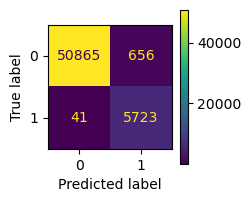

In [27]:
# Métricas de performance
finalAccuracy = accuracy_score(pp_data_outputs, final_prediction)
finalPrecision = precision_score(pp_data_outputs, final_prediction)
finalRecall = recall_score(pp_data_outputs, final_prediction)
finalF1 = f1_score(pp_data_outputs, final_prediction)
finalConfusionMatrix = confusion_matrix(pp_data_outputs, final_prediction)
finalClassificationReport = classification_report(pp_data_outputs, final_prediction)

# Imprime resultados finais
print("Resultado utilizando a função 'voting()'")
print('Accuracy:', finalAccuracy*100)
print('Precision:', finalPrecision*100)
print('Recall:', finalRecall*100)
print('F1-Score:', finalF1*100)
print(finalConfusionMatrix)
ConfusionMatrixDisplay(finalConfusionMatrix).plot()
plt.show()

Resultado utilizando a floresta aleatória
Accuracy: 98.87754211399144
Precision: 90.40555467887013
Recall: 99.39278278972935
F1-Score: 94.68638955458226
[[50913   608]
 [   35  5729]]


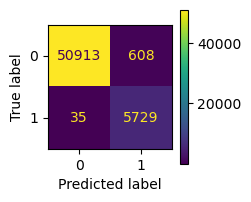

In [28]:
# Métricas de performance
finalAccuracy = accuracy_score(pp_data_outputs, final_ensemble_prediction)
finalPrecision = precision_score(pp_data_outputs, final_ensemble_prediction)
finalRecall = recall_score(pp_data_outputs, final_ensemble_prediction)
finalF1 = f1_score(pp_data_outputs, final_ensemble_prediction)
finalConfusionMatrix = confusion_matrix(pp_data_outputs, final_ensemble_prediction)
finalClassificationReport = classification_report(pp_data_outputs, final_ensemble_prediction)

# Imprime resultados finais
print("Resultado utilizando a floresta aleatória")
print('Accuracy:', finalAccuracy*100)
print('Precision:', finalPrecision*100)
print('Recall:', finalRecall*100)
print('F1-Score:', finalF1*100)
print(finalConfusionMatrix)
ConfusionMatrixDisplay(finalConfusionMatrix).plot()
plt.show()

In [29]:
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
# Conifer Settings 
cfg = {'Backend' : 'vhdl',
              'ProjectName' : 'my-prj',
              'OutputDir'   : 'my-conifer-prj',
              'Precision'   : 'ap_fixed<24,12>', #exemplo: <18,12> -> 18 bits total, 12 para representar a parte inteira e 18 - 12 = 6 para representação decimal
              'XilinxPart' : 'xc7s100',
              'ClockPeriod' : '5'}

# Set the output directory to something unique
cfg['OutputDir'] = './Projects/prj_FPGA1_{}'.format(cfg['Precision'])

In [30]:
# Create and compile the model
FPGA_1 = conifer.converters.convert_from_sklearn(ensemble_decision_tree, cfg)
#Compila modelo 
FPGA_1.compile()

DEBUG:conifer.model:Converted BDT with parameters {"max_depth": 8, "n_trees": 3, "n_features": 3, "n_classes": 2}
INFO:conifer.model:Saving model to ./Projects/prj_FPGA1_ap_fixed<24,12>
INFO:conifer.backends.vhdl.writer:Writing project to ./Projects/prj_FPGA1_ap_fixed<24,12>


/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


INFO:conifer.backends.vhdl.writer:Compiling simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Compiling simulation with command "sh xsim_compile.sh > xsim_compile.log"


In [31]:
pp_dataset = pre_processing("./Datasets/DatasetT3.csv")
display(pp_dataset)

#Define as entradas e as saídas do dataset
pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
display(pp_data_inputs)

pp_data_outputs = pp_dataset[['Decisão']]
display(pp_data_outputs)

pp_data_inputs = pp_data_inputs.to_numpy(dtype=np.float32)

y_hdl = FPGA_1.decision_function(pp_data_inputs) #Calcula a probabilidade da saída ser da classe A dado as entradas x, y, z (HDL)
y_skl = ensemble_decision_tree.predict_proba(pp_data_inputs) #Calcula a probabilidade da saída ser da classe A dado as entradas x, y, z (Sklearn)

,Distância Ruidosa,Velocidade Ruidosa,Capacidade de Frenagem Ruidosa,Decisão
0,0.504450,0.000000,1.3950,1.0
1,0.000000,0.000000,1.1625,1.0
2,0.000000,0.000000,0.9300,1.0
3,1.158221,0.000000,0.7800,1.0
4,0.156073,0.000000,0.6500,1.0
...,...,...,...,...
57280,1998.864111,26.913394,1.3950,0.0
57281,1998.304338,27.914276,1.1625,0.0
57282,1999.635227,27.073422,0.9300,0.0
57283,1999.776292,27.574239,0.7800,0.0


,Distância Ruidosa,Velocidade Ruidosa,Capacidade de Frenagem Ruidosa
0,0.504450,0.000000,1.3950
1,0.000000,0.000000,1.1625
2,0.000000,0.000000,0.9300
3,1.158221,0.000000,0.7800
4,0.156073,0.000000,0.6500
...,...,...,...
57280,1998.864111,26.913394,1.3950
57281,1998.304338,27.914276,1.1625
57282,1999.635227,27.073422,0.9300
57283,1999.776292,27.574239,0.7800


,Decisão
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
57280,0.0
57281,0.0
57282,0.0
57283,0.0


INFO:conifer.backends.vhdl.writer:Running simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Converting X (float32), to integers with scale factor 4096 from ap_fixed<24,12>
DEBUG:conifer.backends.vhdl.writer:Running simulation with command "xsim -R bdt_tb > xsim.log"


/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Accuracy HDL: 98.87579645631492
Precision HDL: 90.39129062795834
Recall HDL: 99.39278278972935
[[50912   609]
 [   35  5729]]
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7f71bbfbe400>


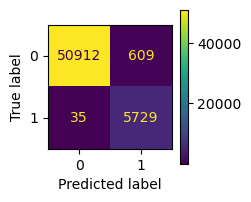

Accuracy SKL: 98.87754211399144
Precision SKL: 90.40555467887013
Recall SKL: 99.39278278972935
[[50913   608]
 [   35  5729]]
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7f71bc2ee5b0>


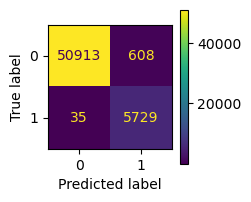

In [32]:
y_hdl_real = [1 if x <= 0.5 else 0 for x in y_hdl] #Retorna a classe (0 ou 1) dado sua probabilidade de acontecer
y_skl_real = ensemble_decision_tree.predict(pp_data_inputs)

finalAccuracy = accuracy_score(pp_data_outputs, y_hdl_real)
finalPrecision = precision_score(pp_data_outputs, y_hdl_real)
finalRecall = recall_score(pp_data_outputs, y_hdl_real)
finalConfusionMatrix = confusion_matrix(pp_data_outputs, y_hdl_real)

print('Accuracy HDL:', finalAccuracy*100)
print('Precision HDL:', finalPrecision*100)
print('Recall HDL:', finalRecall*100)
print(finalConfusionMatrix)
ConfusionMatrixDisplay(finalConfusionMatrix).plot()
plt.show()

finalAccuracy = accuracy_score(pp_data_outputs, y_skl_real)
finalPrecision = precision_score(pp_data_outputs, y_skl_real)
finalRecall = recall_score(pp_data_outputs, y_skl_real)
finalConfusionMatrix = confusion_matrix(pp_data_outputs, y_skl_real)

print('Accuracy SKL:', finalAccuracy*100)
print('Precision SKL:', finalPrecision*100)
print('Recall SKL:', finalRecall*100)
print(finalConfusionMatrix)
ConfusionMatrixDisplay(finalConfusionMatrix).plot()
plt.show()

In [42]:
# Synthesize the model
FPGA_1.build()

INFO:conifer.backends.vhdl.writer:build starting 15:26:04
DEBUG:conifer.backends.vhdl.writer:Running build with command "vivado -mode batch -source synth.tcl > build.log"
INFO:conifer.backends.vhdl.writer:build finished 15:31:21 - took 0:05:16.234666


True

<h2>FPGA_2</h2>

In [33]:
pp_dataset = pre_processing("./Datasets/DatasetT&V2.csv")
display(pp_dataset)

#Define as entradas e as saídas do dataset
pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
display(pp_data_inputs)

pp_data_outputs = pp_dataset[['Decisão']]
display(pp_data_outputs)

dtrees_2 = [final_decision_tree_6, final_decision_tree_7, final_decision_tree_8] #Vetor de árvores de decisão

#Classificador dummy para pode utilizar a função conversora (apenas o número de estimadores deve ser compatível com o número de árvores na lista)
starting_random_forest = RandomForestClassifier(n_estimators=len(dtrees_2), max_depth=4, random_state=0).fit(pp_data_inputs, pp_data_outputs)

#Cria árvore de decisão utilizando os estimadores da lista
ensemble_decision_tree_2 = convert_tree_to_random_forest(dtrees_2, starting_random_forest)

,Distância Ruidosa,Velocidade Ruidosa,Capacidade de Frenagem Ruidosa,Decisão
0,1.426390,0.000000,1.3950,1.0
1,0.247126,0.000000,1.1625,1.0
2,1.318730,0.000000,0.9300,1.0
3,0.000000,0.000000,0.7800,1.0
4,1.181601,0.000000,0.6500,1.0
...,...,...,...,...
57280,1998.258208,27.787054,1.3950,0.0
57281,2001.582818,27.545077,1.1625,0.0
57282,2000.103125,29.680000,0.9300,0.0
57283,2001.308140,28.895288,0.7800,0.0


,Distância Ruidosa,Velocidade Ruidosa,Capacidade de Frenagem Ruidosa
0,1.426390,0.000000,1.3950
1,0.247126,0.000000,1.1625
2,1.318730,0.000000,0.9300
3,0.000000,0.000000,0.7800
4,1.181601,0.000000,0.6500
...,...,...,...
57280,1998.258208,27.787054,1.3950
57281,2001.582818,27.545077,1.1625
57282,2000.103125,29.680000,0.9300
57283,2001.308140,28.895288,0.7800


,Decisão
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
57280,0.0
57281,0.0
57282,0.0
57283,0.0


/tmp/ipykernel_3448/788140685.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  starting_random_forest = RandomForestClassifier(n_estimators=len(dtrees_2), max_depth=4, random_state=0).fit(pp_data_inputs, pp_data_outputs)


In [34]:
pp_dataset = pre_processing("./Datasets/DatasetT3.csv")
display(pp_dataset)

#Define as entradas e as saídas do dataset
pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
display(pp_data_inputs)

pp_data_outputs = pp_dataset[['Decisão']]
display(pp_data_outputs)

decision_trees_2 = dtrees_2

#Comparação entre votação da função criada e a floresta aleatória criada manualmente
#De forma geral a função "voting" apresenta melhor recall e menor precisão, as diferenças são pequenas em comparação com a floresta aleatória criada
final_prediction_2 = voting("./Datasets/DatasetT3.csv", decision_trees_2)

final_ensemble_prediction_2 = ensemble_decision_tree_2.predict(pp_data_inputs)

,Distância Ruidosa,Velocidade Ruidosa,Capacidade de Frenagem Ruidosa,Decisão
0,0.504450,0.000000,1.3950,1.0
1,0.000000,0.000000,1.1625,1.0
2,0.000000,0.000000,0.9300,1.0
3,1.158221,0.000000,0.7800,1.0
4,0.156073,0.000000,0.6500,1.0
...,...,...,...,...
57280,1998.864111,26.913394,1.3950,0.0
57281,1998.304338,27.914276,1.1625,0.0
57282,1999.635227,27.073422,0.9300,0.0
57283,1999.776292,27.574239,0.7800,0.0


,Distância Ruidosa,Velocidade Ruidosa,Capacidade de Frenagem Ruidosa
0,0.504450,0.000000,1.3950
1,0.000000,0.000000,1.1625
2,0.000000,0.000000,0.9300
3,1.158221,0.000000,0.7800
4,0.156073,0.000000,0.6500
...,...,...,...
57280,1998.864111,26.913394,1.3950
57281,1998.304338,27.914276,1.1625
57282,1999.635227,27.073422,0.9300
57283,1999.776292,27.574239,0.7800


,Decisão
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
57280,0.0
57281,0.0
57282,0.0
57283,0.0


Resultado utilizando a função 'voting()'
Accuracy: 99.2109627302086
Precision: 93.46972176759411
Recall: 99.08049965301873
F1-Score: 96.19336365167594
[[51122   399]
 [   53  5711]]
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7f71bce65430>


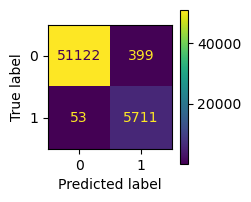

In [35]:
# Métricas de performance
finalAccuracy = accuracy_score(pp_data_outputs, final_prediction_2)
finalPrecision = precision_score(pp_data_outputs, final_prediction_2)
finalRecall = recall_score(pp_data_outputs, final_prediction_2)
finalF1 = f1_score(pp_data_outputs, final_prediction_2)
finalConfusionMatrix = confusion_matrix(pp_data_outputs, final_prediction_2)
finalClassificationReport = classification_report(pp_data_outputs, final_prediction_2)

# Imprime resultados finais
print("Resultado utilizando a função 'voting()'")
print('Accuracy:', finalAccuracy*100)
print('Precision:', finalPrecision*100)
print('Recall:', finalRecall*100)
print('F1-Score:', finalF1*100)
print(finalConfusionMatrix)
ConfusionMatrixDisplay(finalConfusionMatrix).plot()
plt.show()

Resultado utilizando a floresta aleatória
Accuracy: 99.2755520642402
Precision: 94.22854307921284
Recall: 98.85496183206108
F1-Score: 96.48632630598595
[[51172   349]
 [   66  5698]]
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7f71bc204a30>


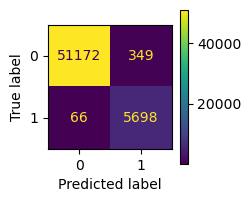

In [36]:
# Métricas de performance
finalAccuracy = accuracy_score(pp_data_outputs, final_ensemble_prediction_2)
finalPrecision = precision_score(pp_data_outputs, final_ensemble_prediction_2)
finalRecall = recall_score(pp_data_outputs, final_ensemble_prediction_2)
finalF1 = f1_score(pp_data_outputs, final_ensemble_prediction_2)
finalConfusionMatrix = confusion_matrix(pp_data_outputs, final_ensemble_prediction_2)
finalClassificationReport = classification_report(pp_data_outputs, final_ensemble_prediction_2)

# Imprime resultados finais
print("Resultado utilizando a floresta aleatória")
print('Accuracy:', finalAccuracy*100)
print('Precision:', finalPrecision*100)
print('Recall:', finalRecall*100)
print('F1-Score:', finalF1*100)
print(finalConfusionMatrix)
ConfusionMatrixDisplay(finalConfusionMatrix).plot()
plt.show()

In [37]:
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
# Conifer Settings 
cfg = {'Backend' : 'vhdl',
              'ProjectName' : 'my-prj',
              'OutputDir'   : 'my-conifer-prj',
              'Precision'   : 'ap_fixed<24,12>', #exemplo: <18,12> -> 18 bits total, 12 para representar a parte inteira e 18 - 12 = 6 para representação decimal
              'XilinxPart' : 'xc7s100',
              'ClockPeriod' : '5'}

# Set the output directory to something unique
cfg['OutputDir'] = './Projects/prj_FPGA2_{}'.format(cfg['Precision'])

In [38]:
# Create and compile the model
FPGA_2 = conifer.converters.convert_from_sklearn(ensemble_decision_tree_2, cfg)
#Compila modelo 
FPGA_2.compile()

DEBUG:conifer.model:Converted BDT with parameters {"max_depth": 9, "n_trees": 3, "n_features": 3, "n_classes": 2}
INFO:conifer.model:Saving model to ./Projects/prj_FPGA2_ap_fixed<24,12>
INFO:conifer.backends.vhdl.writer:Writing project to ./Projects/prj_FPGA2_ap_fixed<24,12>
INFO:conifer.backends.vhdl.writer:Compiling simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Compiling simulation with command "sh xsim_compile.sh > xsim_compile.log"


/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


In [39]:
pp_dataset = pre_processing("./Datasets/DatasetT3.csv")
display(pp_dataset)

#Define as entradas e as saídas do dataset
pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
display(pp_data_inputs)

pp_data_outputs = pp_dataset[['Decisão']]
display(pp_data_outputs)

pp_data_inputs = pp_data_inputs.to_numpy(dtype=np.float32)

y_hdl_2 = FPGA_2.decision_function(pp_data_inputs) #Calcula a probabilidade da saída ser da classe A dado as entradas x, y, z (HDL)
y_skl_2 = ensemble_decision_tree_2.predict_proba(pp_data_inputs) #Calcula a probabilidade da saída ser da classe A dado as entradas x, y, z (Sklearn)

,Distância Ruidosa,Velocidade Ruidosa,Capacidade de Frenagem Ruidosa,Decisão
0,0.504450,0.000000,1.3950,1.0
1,0.000000,0.000000,1.1625,1.0
2,0.000000,0.000000,0.9300,1.0
3,1.158221,0.000000,0.7800,1.0
4,0.156073,0.000000,0.6500,1.0
...,...,...,...,...
57280,1998.864111,26.913394,1.3950,0.0
57281,1998.304338,27.914276,1.1625,0.0
57282,1999.635227,27.073422,0.9300,0.0
57283,1999.776292,27.574239,0.7800,0.0


,Distância Ruidosa,Velocidade Ruidosa,Capacidade de Frenagem Ruidosa
0,0.504450,0.000000,1.3950
1,0.000000,0.000000,1.1625
2,0.000000,0.000000,0.9300
3,1.158221,0.000000,0.7800
4,0.156073,0.000000,0.6500
...,...,...,...
57280,1998.864111,26.913394,1.3950
57281,1998.304338,27.914276,1.1625
57282,1999.635227,27.073422,0.9300
57283,1999.776292,27.574239,0.7800


,Decisão
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
57280,0.0
57281,0.0
57282,0.0
57283,0.0


INFO:conifer.backends.vhdl.writer:Running simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Converting X (float32), to integers with scale factor 4096 from ap_fixed<24,12>
DEBUG:conifer.backends.vhdl.writer:Running simulation with command "xsim -R bdt_tb > xsim.log"


/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Accuracy HDL: 99.26682377585755
Precision HDL: 94.12153236459709
Recall HDL: 98.88965995836226
[[51165   356]
 [   64  5700]]
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7f71bbf7adf0>


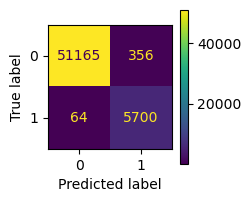

Accuracy SKL: 99.2755520642402
Precision SKL: 94.22854307921284
Recall SKL: 98.85496183206108
[[51172   349]
 [   66  5698]]
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7f71bad9d6d0>


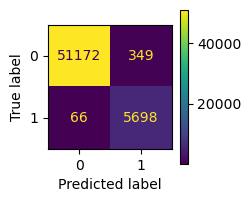

In [40]:
y_hdl_real_2 = [1 if x <= 0.5 else 0 for x in y_hdl_2] #Retorna a classe (0 ou 1) dado sua probabilidade de acontecer
y_skl_real_2 = ensemble_decision_tree_2.predict(pp_data_inputs)

finalAccuracy = accuracy_score(pp_data_outputs, y_hdl_real_2)
finalPrecision = precision_score(pp_data_outputs, y_hdl_real_2)
finalRecall = recall_score(pp_data_outputs, y_hdl_real_2)
finalConfusionMatrix = confusion_matrix(pp_data_outputs, y_hdl_real_2)

print('Accuracy HDL:', finalAccuracy*100)
print('Precision HDL:', finalPrecision*100)
print('Recall HDL:', finalRecall*100)
print(finalConfusionMatrix)
ConfusionMatrixDisplay(finalConfusionMatrix).plot()
plt.show()

finalAccuracy = accuracy_score(pp_data_outputs, y_skl_real_2)
finalPrecision = precision_score(pp_data_outputs, y_skl_real_2)
finalRecall = recall_score(pp_data_outputs, y_skl_real_2)
finalConfusionMatrix = confusion_matrix(pp_data_outputs, y_skl_real_2)

print('Accuracy SKL:', finalAccuracy*100)
print('Precision SKL:', finalPrecision*100)
print('Recall SKL:', finalRecall*100)
print(finalConfusionMatrix)
ConfusionMatrixDisplay(finalConfusionMatrix).plot()
plt.show()

In [43]:
# Synthesize the model
FPGA_2.build()

INFO:conifer.backends.vhdl.writer:build starting 15:31:21
DEBUG:conifer.backends.vhdl.writer:Running build with command "vivado -mode batch -source synth.tcl > build.log"
INFO:conifer.backends.vhdl.writer:build finished 15:54:25 - took 0:23:04.095689


True

<h2>Conifer voting</h2>

<h3>Conifer</h3>

<h4>simple mean</h4>

In [ ]:
pp_dataset = pre_processing("./Datasets/DatasetT3.csv")
pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
pp_data_outputs = pp_dataset[['Decisão']]

predict_prob_1_hdl = y_hdl
predict_prob_2_hdl = y_hdl_2

mean_prob_hdl = np.array([sum(x) for x in zip(predict_prob_1_hdl, predict_prob_2_hdl)])*0.5
mean_pred_hdl = [1 if x <= 0.5 else 0 for x in mean_prob_hdl]

finalRecall_hdl_1 = recall_score(pp_data_outputs, y_hdl_real)
finalRecall_hdl_2 = recall_score(pp_data_outputs, y_hdl_real_2)
finalRecall_mean_hdl = recall_score(pp_data_outputs, mean_pred_hdl)

finalPrecision_hdl_1 = precision_score(pp_data_outputs, y_hdl_real)
finalPrecision_hdl_2 = precision_score(pp_data_outputs, y_hdl_real_2)
finalPrecision_mean_hdl = precision_score(pp_data_outputs, mean_pred_hdl)

finalAccuracy_hdl_1 = accuracy_score(pp_data_outputs, y_hdl_real)
finalAccuracy_hdl_2 = accuracy_score(pp_data_outputs, y_hdl_real_2)
finalAccuracy_mean_hdl = accuracy_score(pp_data_outputs, mean_pred_hdl)

print('Accuracy HDL ensemble 1:', finalAccuracy_hdl_1*100)
print('Accuracy HDL ensemble 2:', finalAccuracy_hdl_2*100)
print('Accuracy mean:', finalAccuracy_mean_hdl*100)
print()

print('Precision HDL ensemble 1:', finalPrecision_hdl_1*100)
print('Precision HDL ensemble 2:', finalPrecision_hdl_2*100)
print('Precision mean:', finalPrecision_mean_hdl*100)
print()
 
print('Recall HDL ensemble 1:', finalRecall_hdl_1*100)
print('Recall HDL ensemble 2:', finalRecall_hdl_2*100)
print('Recall mean:', finalRecall_mean_hdl*100)

<h4>pondered average</h4>

In [ ]:
#Descobre qual conjunto de estimadores tem a melhor precisão e recall
pp_dataset = pre_processing("./Datasets/DatasetT2.csv")
pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
pp_data_inputs = pp_data_inputs.to_numpy()
pp_data_outputs = pp_dataset[['Decisão']]

predict_1_prob = FPGA_1.decision_function(pp_data_inputs)
predict_1 = [1 if x <= 0.5 else 0 for x in predict_1_prob] #Retorna a classe (0 ou 1) dado sua probabilidade de acontecer

predict_2_prob = FPGA_2.decision_function(pp_data_inputs)
predict_2 = [1 if x <= 0.5 else 0 for x in predict_2_prob] #Retorna a classe (0 ou 1) dado sua probabilidade de acontecer

recall_T_hdl_1 = recall_score(pp_data_outputs, predict_1)
recall_T_hdl_2 = recall_score(pp_data_outputs, predict_2)

precision_T_hdl_1 = precision_score(pp_data_outputs, predict_1)
precision_T_hdl_2 = precision_score(pp_data_outputs, predict_2)

if (recall_T_hdl_1 > recall_T_hdl_2):
    recall_model = FPGA_1
else:
    recall_model = FPGA_2

if (precision_T_hdl_1 > precision_T_hdl_2):
    precision_model = FPGA_1
else:
    precision_model = FPGA_2

# Realiza a média ponderada
pp_dataset = pre_processing("./Datasets/DatasetT3.csv")
pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
pp_data_inputs = pp_data_inputs.to_numpy()
pp_data_outputs = pp_dataset[['Decisão']]

precision_predict_proba = precision_model.decision_function(pp_data_inputs)
recall_predict_proba = recall_model.decision_function(pp_data_inputs)

pondered_prob = np.zeros(len(pp_data_inputs))

distance = [row[0] for row in pp_data_inputs]
speed = [row[1] for row in pp_data_inputs]
brake_capacity = [row[2] for row in pp_data_inputs]

for i in range(len(distance)):
    if (distance[i] > 705):
        pondered_prob[i] = np.average([precision_predict_proba[i], recall_predict_proba[i]], weights =(10, 1))
    else:
        pondered_prob[i] = np.average([precision_predict_proba[i], recall_predict_proba[i]], weights =(1, 1))

pondered_pred = [1 if x <= 0.5 else 0 for x in pondered_prob]

predict_1_prob = FPGA_1.decision_function(pp_data_inputs)
predict_1 = [1 if x <= 0.5 else 0 for x in predict_1_prob]

predict_2_prob = FPGA_2.decision_function(pp_data_inputs)
predict_2 = [1 if x <= 0.5 else 0 for x in predict_2_prob] #

finalRecall_skl_1 = recall_score(pp_data_outputs, predict_1)
finalRecall_skl_2 = recall_score(pp_data_outputs, predict_2)
finalRecall_mean = recall_score(pp_data_outputs, pondered_pred)

finalPrecision_skl_1 = precision_score(pp_data_outputs, predict_1)
finalPrecision_skl_2 = precision_score(pp_data_outputs, predict_2)
finalPrecision_mean = precision_score(pp_data_outputs, pondered_pred)

finalAccuracy_skl_1 = accuracy_score(pp_data_outputs, predict_1)
finalAccuracy_skl_2 = accuracy_score(pp_data_outputs, predict_2)
finalAccuracy_mean = accuracy_score(pp_data_outputs, pondered_pred)

print()
print('Accuracy SKL ensemble 1:', finalAccuracy_skl_1*100)
print('Accuracy SKL ensemble 2:', finalAccuracy_skl_2*100)
print('Accuracy mean:', finalAccuracy_mean*100)
print()

print('Precision SKL ensemble 1:', finalPrecision_skl_1*100)
print('Precision SKL ensemble 2:', finalPrecision_skl_2*100)
print('Precision mean:', finalPrecision_mean*100)
print()
 
print('Recall SKL ensemble 1:', finalRecall_skl_1*100)
print('Recall SKL ensemble 2:', finalRecall_skl_2*100)
print('Recall mean:', finalRecall_mean*100)

<h4>confidence</h4>

In [ ]:
#Descobre qual conjunto de estimadores tem a melhor precisão e recall
pp_dataset = pre_processing("./Datasets/DatasetT2.csv")
pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
pp_data_inputs = pp_data_inputs.to_numpy()
pp_data_outputs = pp_dataset[['Decisão']]

predict_1_prob = FPGA_1.decision_function(pp_data_inputs)
predict_1 = [1 if x <= 0.5 else 0 for x in predict_1_prob] #Retorna a classe (0 ou 1) dado sua probabilidade de acontecer

predict_2_prob = FPGA_2.decision_function(pp_data_inputs)
predict_2 = [1 if x <= 0.5 else 0 for x in predict_2_prob] #Retorna a classe (0 ou 1) dado sua probabilidade de acontecer

recall_T_hdl_1 = recall_score(pp_data_outputs, predict_1)
recall_T_hdl_2 = recall_score(pp_data_outputs, predict_2)

precision_T_hdl_1 = precision_score(pp_data_outputs, predict_1)
precision_T_hdl_2 = precision_score(pp_data_outputs, predict_2)

if (recall_T_hdl_1 > recall_T_hdl_2):
    recall_model = FPGA_1
else:
    recall_model = FPGA_2

if (precision_T_hdl_1 > precision_T_hdl_2):
    precision_model = FPGA_1
else:
    precision_model = FPGA_2

# Realiza a média ponderada
pp_dataset = pre_processing("./Datasets/DatasetT3.csv")
pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
pp_data_inputs = pp_data_inputs.to_numpy()
pp_data_outputs = pp_dataset[['Decisão']]

precision_predict_proba = precision_model.decision_function(pp_data_inputs)
predict_precision = [1 if x <= 0.5 else 0 for x in precision_predict_proba] 

recall_predict_proba = recall_model.decision_function(pp_data_inputs)
predict_recall = [1 if x <= 0.5 else 0 for x in recall_predict_proba] 

pondered_prob = np.zeros(len(pp_data_inputs))

for i in range(len(pp_data_inputs)):
    if(recall_predict_proba[i] < 0.5 and precision_predict_proba[i] < 0.5): #FPGA recall diz 1 e FPGA precision diz 1
        pondered_prob[i] = recall_predict_proba[i]
    if(recall_predict_proba[i] > 0.5 and precision_predict_proba[i] < 0.5): #FPGA recall diz 0 e FPGA precision diz 1
        pondered_prob[i] = precision_predict_proba[i]
    if(recall_predict_proba[i] < 0.5 and precision_predict_proba[i] > 0.5): #FPGA recall diz 1 e FPGA precision diz 0
        pondered_prob[i] = recall_predict_proba[i]
    if(recall_predict_proba[i] > 0.5 and precision_predict_proba[i] > 0.5): #FPGA recall diz 0 e FPGA precision diz 0
        pondered_prob[i] = precision_predict_proba[i]

pondered_pred = [1 if x <= 0.5 else 0 for x in pondered_prob]

predict_1_prob = FPGA_1.decision_function(pp_data_inputs)
predict_1 = [1 if x <= 0.5 else 0 for x in predict_1_prob]

predict_2_prob = FPGA_2.decision_function(pp_data_inputs)
predict_2 = [1 if x <= 0.5 else 0 for x in predict_2_prob] 

finalRecall_skl_1 = recall_score(pp_data_outputs, predict_1)
finalRecall_skl_2 = recall_score(pp_data_outputs, predict_2)
finalRecall_mean = recall_score(pp_data_outputs, pondered_pred)

finalPrecision_skl_1 = precision_score(pp_data_outputs, predict_1)
finalPrecision_skl_2 = precision_score(pp_data_outputs, predict_2)
finalPrecision_mean = precision_score(pp_data_outputs, pondered_pred)

finalAccuracy_skl_1 = accuracy_score(pp_data_outputs, predict_1)
finalAccuracy_skl_2 = accuracy_score(pp_data_outputs, predict_2)
finalAccuracy_mean = accuracy_score(pp_data_outputs, pondered_pred)

print()
print('Accuracy SKL ensemble 1:', finalAccuracy_skl_1*100)
print('Accuracy SKL ensemble 2:', finalAccuracy_skl_2*100)
print('Accuracy mean:', finalAccuracy_mean*100)
print()

print('Precision SKL ensemble 1:', finalPrecision_skl_1*100)
print('Precision SKL ensemble 2:', finalPrecision_skl_2*100)
print('Precision mean:', finalPrecision_mean*100)
print()
 
print('Recall SKL ensemble 1:', finalRecall_skl_1*100)
print('Recall SKL ensemble 2:', finalRecall_skl_2*100)
print('Recall mean:', finalRecall_mean*100)

<h3>SKL</h3>

<h4>simple mean</h4>

In [41]:
pp_dataset = pre_processing("./Datasets/DatasetT3.csv")
pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
pp_data_outputs = pp_dataset[['Decisão']]

predict_1 = ensemble_decision_tree.predict_proba(pp_data_inputs)
predict_1 = [row[0] for row in predict_1]

predict_2 = ensemble_decision_tree_2.predict_proba(pp_data_inputs)
predict_2 = [row[0] for row in predict_2]

mean_prob = np.array([np.mean(x) for x in zip(predict_1, predict_2)])

mean_pred = [1 if x <= 0.5 else 0 for x in mean_prob]
normal_pred_1 = ensemble_decision_tree.predict(pp_data_inputs)
normal_pred_2 = ensemble_decision_tree_2.predict(pp_data_inputs)

finalRecall_skl_1_mean = recall_score(pp_data_outputs, normal_pred_1)
finalRecall_skl_2_mean = recall_score(pp_data_outputs, normal_pred_2)
finalRecall_mean = recall_score(pp_data_outputs, mean_pred)

finalPrecision_skl_1_mean = precision_score(pp_data_outputs, normal_pred_1)
finalPrecision_skl_2_mean = precision_score(pp_data_outputs, normal_pred_2)
finalPrecision_mean = precision_score(pp_data_outputs, mean_pred)

finalAccuracy_skl_1_mean = accuracy_score(pp_data_outputs, normal_pred_1)
finalAccuracy_skl_2_mean = accuracy_score(pp_data_outputs, normal_pred_2)
finalAccuracy_mean = accuracy_score(pp_data_outputs, mean_pred)

print('Accuracy SKL ensemble 1:', finalAccuracy_skl_1_mean*100)
print('Accuracy SKL ensemble 2:', finalAccuracy_skl_2_mean*100)
print('Accuracy mean:', finalAccuracy_mean*100)
print()

print('Precision SKL ensemble 1:', finalPrecision_skl_1_mean*100)
print('Precision SKL ensemble 2:', finalPrecision_skl_2_mean*100)
print('Precision mean:', finalPrecision_mean*100)
print()
 
print('Recall SKL ensemble 1:', finalRecall_skl_1_mean*100)
print('Recall SKL ensemble 2:', finalRecall_skl_2_mean*100)
print('Recall mean:', finalRecall_mean*100)

Accuracy SKL ensemble 1: 98.87754211399144
Accuracy SKL ensemble 2: 99.2755520642402
Accuracy mean: 99.13589945011783

Precision SKL ensemble 1: 90.40555467887013
Precision SKL ensemble 2: 94.22854307921284
Precision mean: 92.53996447602132

Recall SKL ensemble 1: 99.39278278972935
Recall SKL ensemble 2: 98.85496183206108
Recall mean: 99.42748091603053


<h4>pondered average</h4>

In [ ]:
#Descobre qual conjunto de estimadores tem a melhor precisão e recall

pp_dataset = pre_processing("./Datasets/DatasetT2.csv")
pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
pp_data_outputs = pp_dataset[['Decisão']]

predict_1 = ensemble_decision_tree.predict(pp_data_inputs)
predict_2 = ensemble_decision_tree_2.predict(pp_data_inputs)

recall_T_skl_1 = recall_score(pp_data_outputs, predict_1)
recall_T_skl_2 = recall_score(pp_data_outputs, predict_2)

precision_T_skl_1 = precision_score(pp_data_outputs, predict_1)
precision_T_skl_2 = precision_score(pp_data_outputs, predict_2)

if (recall_T_skl_1 > recall_T_skl_2):
    recall_rf = ensemble_decision_tree
else:
    recall_rf = ensemble_decision_tree_2

if (precision_T_skl_1 > precision_T_skl_2):
    precision_rf = ensemble_decision_tree
else:
    precision_rf = ensemble_decision_tree_2

# Realiza a média ponderada

pp_dataset = pre_processing("./Datasets/DatasetT3.csv")
pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
pp_data_outputs = pp_dataset[['Decisão']]

precision_predict_proba = precision_rf.predict_proba(pp_data_inputs)
precision_predict_proba = [row[0] for row in precision_predict_proba]

recall_predict_proba = recall_rf.predict_proba(pp_data_inputs)
recall_predict_proba = [row[0] for row in recall_predict_proba]

pondered_prob = np.zeros(len(pp_data_inputs))
pp_data_inputs = pp_data_inputs.to_numpy()

distance = [row[0] for row in pp_data_inputs]
speed = [row[1] for row in pp_data_inputs]
brake_capacity = [row[2] for row in pp_data_inputs]

for i in range(len(distance)):
    if (distance[i] > 705):
        pondered_prob[i] = np.average([precision_predict_proba[i], recall_predict_proba[i]], weights =(10, 1))
    else:
        pondered_prob[i] = np.average([precision_predict_proba[i], recall_predict_proba[i]], weights =(1, 10))

pondered_pred = [1 if x <= 0.5 else 0 for x in pondered_prob]
normal_pred_1 = precision_rf.predict(pp_data_inputs)
normal_pred_2 = recall_rf.predict(pp_data_inputs)

finalRecall_skl_1_pondered = recall_score(pp_data_outputs, normal_pred_1)
finalRecall_skl_2_pondered = recall_score(pp_data_outputs, normal_pred_2)
finalRecall_pondered = recall_score(pp_data_outputs, pondered_pred)

finalPrecision_skl_1_pondered = precision_score(pp_data_outputs, normal_pred_1)
finalPrecision_skl_2_pondered = precision_score(pp_data_outputs, normal_pred_2)
finalPrecision_pondered = precision_score(pp_data_outputs, pondered_pred)

finalAccuracy_skl_1_pondered = accuracy_score(pp_data_outputs, normal_pred_1)
finalAccuracy_skl_2_pondered = accuracy_score(pp_data_outputs, normal_pred_2)
finalAccuracy_pondered = accuracy_score(pp_data_outputs, pondered_pred)

print('Accuracy SKL ensemble 1:', finalAccuracy_skl_1_pondered*100)
print('Accuracy SKL ensemble 2:', finalAccuracy_skl_2_pondered*100)
print('Accuracy pondered average:', finalAccuracy_pondered*100)
print()

print('Precision SKL ensemble 1:', finalPrecision_skl_1_pondered*100)
print('Precision SKL ensemble 2:', finalPrecision_skl_2_pondered*100)
print('Precision pondered average:', finalPrecision_pondered*100)
print()
 
print('Recall SKL ensemble 1:', finalRecall_skl_1_pondered*100)
print('Recall SKL ensemble 2:', finalRecall_skl_2_pondered*100)
print('Recall pondered average:', finalRecall_pondered*100)

<h4>confidence</h4>

In [ ]:
#Descobre qual conjunto de estimadores tem a melhor precisão e recall

pp_dataset = pre_processing("./Datasets/DatasetT2.csv")
pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
pp_data_outputs = pp_dataset[['Decisão']]

predict_1 = ensemble_decision_tree.predict(pp_data_inputs)
predict_2 = ensemble_decision_tree_2.predict(pp_data_inputs)

recall_T_skl_1 = recall_score(pp_data_outputs, predict_1)
recall_T_skl_2 = recall_score(pp_data_outputs, predict_2)

precision_T_skl_1 = precision_score(pp_data_outputs, predict_1)
precision_T_skl_2 = precision_score(pp_data_outputs, predict_2)

if (recall_T_skl_1 > recall_T_skl_2):
    recall_rf = ensemble_decision_tree
else:
    recall_rf = ensemble_decision_tree_2

if (precision_T_skl_1 > precision_T_skl_2):
    precision_rf = ensemble_decision_tree
else:
    precision_rf = ensemble_decision_tree_2


pp_dataset = pre_processing("./Datasets/DatasetT3.csv")
pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
pp_data_outputs = pp_dataset[['Decisão']]

predict_precision = precision_rf.predict_proba(pp_data_inputs)
predict_precision = [row[0] for row in predict_precision]

predict_recall = recall_rf.predict_proba(pp_data_inputs)
predict_recall = [row[0] for row in predict_recall]

pondered_prob = np.zeros(len(pp_data_inputs))
pp_data_inputs = pp_data_inputs.to_numpy()
# 1 se prob <= 0.5

for i in range(len(pp_data_inputs)):
    if(predict_recall[i] < 0.5 and predict_precision[i] < 0.5): #FPGA recall diz 1 e FPGA precision diz 1
        pondered_prob[i] = predict_recall[i]
    if(predict_recall[i] > 0.5 and predict_precision[i] < 0.5): #FPGA recall diz 0 e FPGA precision diz 1
        pondered_prob[i] = predict_precision[i]
    if(predict_recall[i] < 0.5 and predict_precision[i] > 0.5): #FPGA recall diz 1 e FPGA precision diz 0
        pondered_prob[i] = predict_recall[i]
    if(predict_recall[i] > 0.5 and predict_precision[i] > 0.5): #FPGA recall diz 0 e FPGA precision diz 0
        pondered_prob[i] = predict_precision[i]

pondered_pred = [1 if x <= 0.5 else 0 for x in pondered_prob]
normal_pred_1 = ensemble_decision_tree.predict(pp_data_inputs)
normal_pred_2 = ensemble_decision_tree_2.predict(pp_data_inputs)

finalRecall_skl_1_confidence = recall_score(pp_data_outputs, normal_pred_1)
finalRecall_skl_2_confidence = recall_score(pp_data_outputs, normal_pred_2)
finalRecall_confidence = recall_score(pp_data_outputs, pondered_pred)

finalPrecision_skl_1_confidence = precision_score(pp_data_outputs, normal_pred_1)
finalPrecision_skl_2_confidence = precision_score(pp_data_outputs, normal_pred_2)
finalPrecision_confidence = precision_score(pp_data_outputs, pondered_pred)

finalAccuracy_skl_1_confidence = accuracy_score(pp_data_outputs, normal_pred_1)
finalAccuracy_skl_2_confidence = accuracy_score(pp_data_outputs, normal_pred_2)
finalAccuracy_confidence = accuracy_score(pp_data_outputs, pondered_pred)

print('Accuracy SKL ensemble 1:', finalAccuracy_skl_1_confidence*100)
print('Accuracy SKL ensemble 2:', finalAccuracy_skl_2_confidence*100)
print('Accuracy confidence:', finalAccuracy_confidence*100)
print()

print('Precision SKL ensemble 1:', finalPrecision_skl_1_confidence*100)
print('Precision SKL ensemble 2:', finalPrecision_skl_2_confidence*100)
print('Precision confidence:', finalPrecision_confidence*100)
print()
 
print('Recall SKL ensemble 1:', finalRecall_skl_1_confidence*100)
print('Recall SKL ensemble 2:', finalRecall_skl_2_confidence*100)
print('Recall confidence:', finalRecall_confidence*100)

In [ ]:
#Grava métricas em um arquivo .txt
import sys

original_stdout = sys.stdout
with open(f"voting_results", 'w') as f:
    sys.stdout = f
    print('********************************************')
    print('Accuracy SKL ensemble 1:', finalAccuracy_skl_1_mean*100)
    print('Accuracy SKL ensemble 2:', finalAccuracy_skl_2_mean*100)
    print('Accuracy mean:', finalAccuracy_mean*100)
    print()
    print('Precision SKL ensemble 1:', finalPrecision_skl_1_mean*100)
    print('Precision SKL ensemble 2:', finalPrecision_skl_2_mean*100)
    print('Precision mean:', finalPrecision_mean*100)
    print()
    print('Recall SKL ensemble 1:', finalRecall_skl_1_mean*100)
    print('Recall SKL ensemble 2:', finalRecall_skl_2_mean*100)
    print('Recall mean:', finalRecall_mean*100)
    print('********************************************')
    print('Accuracy SKL ensemble 1:', finalAccuracy_skl_1_pondered*100)
    print('Accuracy SKL ensemble 2:', finalAccuracy_skl_2_pondered*100)
    print('Accuracy pondered average:', finalAccuracy_pondered*100)
    print()
    print('Precision SKL ensemble 1:', finalPrecision_skl_1_pondered*100)
    print('Precision SKL ensemble 2:', finalPrecision_skl_2_pondered*100)
    print('Precision pondered average:', finalPrecision_pondered*100)
    print()
    print('Recall SKL ensemble 1:', finalRecall_skl_1_pondered*100)
    print('Recall SKL ensemble 2:', finalRecall_skl_2_pondered*100)
    print('Recall pondered average:', finalRecall_pondered*100)
    print('********************************************')
    print('Accuracy SKL ensemble 1:', finalAccuracy_skl_1_confidence*100)
    print('Accuracy SKL ensemble 2:', finalAccuracy_skl_2_confidence*100)
    print('Accuracy confidence:', finalAccuracy_confidence*100)
    print()
    print('Precision SKL ensemble 1:', finalPrecision_skl_1_confidence*100)
    print('Precision SKL ensemble 2:', finalPrecision_skl_2_confidence*100)
    print('Precision confidence:', finalPrecision_confidence*100)
    print()
    print('Recall SKL ensemble 1:', finalRecall_skl_1_confidence*100)
    print('Recall SKL ensemble 2:', finalRecall_skl_2_confidence*100)
    print('Recall confidence:', finalRecall_confidence*100)
    sys.stdout = original_stdout

<h1>depth-LUT analysis</h1>

In [ ]:
depths = [int(x) for x in range(2,10)]
rf_classifiers = []

pp_dataset = pre_processing("./Datasets/DatasetT&V.csv")
pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
pp_data_outputs = pp_dataset[['Decisão']]

logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
# Conifer Settings 
cfg = {'Backend' : 'vhdl',
        'ProjectName' : 'my-prj',
        'OutputDir'   : 'my-conifer-prj',
        'Precision'   : 'ap_fixed<19,12>', #exemplo: <18,12> -> 18 bits total, 12 para representar a parte inteira e 18 - 12 = 6 para representação decimal
        'XilinxPart' : 'xc7s100',
        'ClockPeriod' : '5'}

for depth in depths:
    rf = RandomForestClassifier(n_estimators=3, max_depth=depth).fit(pp_data_inputs, np.ravel(pp_data_outputs))
    rf_classifiers.append(rf)

pp_dataset = pre_processing("./Datasets/DatasetT3.csv")
pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
pp_data_outputs = pp_dataset[['Decisão']]

for i in range(len(rf_classifiers)):
    predicted = rf_classifiers[i].predict(pp_data_inputs)
    finalRecall = recall_score(pp_data_outputs, predicted)
    print(f"depth = {rf_classifiers[i].max_depth} | recall = {finalRecall*100}%")

    cfg['OutputDir'] = 'prj_{}'.format(f"LUTs - depth = {rf_classifiers[i].max_depth}")
    model = conifer.converters.convert_from_sklearn(rf_classifiers[i], cfg)
    model.compile()
    model.build()

<h1>error analysis</h1>

<h2>values and predictions error</h2>

In [ ]:
def values_and_predictions_error(model, dataset = './Datasets/DatasetT3.csv'):
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import mean_squared_error

    pp_dataset = pre_processing(dataset)
    pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
    pp_data_outputs = pp_dataset[['Decisão']]
    pp_data_inputs = pp_data_inputs.to_numpy(dtype=np.float32)

    dataset = dataset.replace(".csv","")
    
    #Retorna apenas a primeira coluna de probabilidades (segunda coluna é a prob complementar)
    predict_hdl = model.decision_function(pp_data_inputs)
    predict_skl = ensemble_decision_tree.predict_proba(pp_data_inputs)
    predict_skl = [row[0] for row in predict_skl]

    #Calcula métricas
    erro = abs(predict_hdl - predict_skl)
    mean = mean_absolute_error(predict_skl, predict_hdl)
    mse = mean_squared_error(predict_skl, predict_hdl, squared=True)
    rmse = mean_squared_error(predict_skl, predict_hdl, squared=False)
    std = np.std(erro)
    q = 75
    percentile = np.percentile(erro, q)

    predict_hdl_final = [1 if x <= 0.5 else 0 for x in predict_hdl]
    predict_skl_final = [1 if x <= 0.5 else 0 for x in predict_skl]

    #Métricas de performance
    recall_HDL = recall_score(pp_data_outputs, predict_hdl_final)
    recall_SKL = recall_score(pp_data_outputs, predict_skl_final)

    precision_HDL = precision_score(pp_data_outputs, predict_hdl_final)
    precision_SKL = precision_score(pp_data_outputs, predict_skl_final)

    accuracy_HDL = accuracy_score(pp_data_outputs, predict_hdl_final)
    accuracy_SKL = accuracy_score(pp_data_outputs, predict_skl_final)

    error_recall = abs(recall_SKL-recall_HDL)*100

    #Grava métricas em um arquivo .txt
    original_stdout = sys.stdout
    with open(f"Errors_{model.config['OutputDir']}_{dataset}.txt", 'w') as f:
        sys.stdout = f
        print(f"{model.config['OutputDir']}_{dataset}.txt")
        print(f"mean absolute error = {mean*100}%")
        print(f"standard deviation = {std*100}%")
        print(f"mean squared error = {mse*100}%")
        print(f"root mean squared error = {rmse*100}%")
        print(f"error percentile {q}% = {percentile*100}%")
        print("********************************************")
        print(f"Recall SKL = {recall_SKL*100}%")
        print(f"Recall HDL = {recall_HDL*100}%")
        print(f"Precision SKL = {precision_SKL*100}%")
        print(f"Precision HDL = {precision_HDL*100}%")
        print(f"Accuracy SKL = {accuracy_SKL*100}%")
        print(f"Accuracy HDL = {accuracy_HDL*100}%")
        sys.stdout = original_stdout 

    print(f"{model.config['OutputDir']}_{dataset}.txt")
    print(f"mean absolute error = {mean*100}%")
    print(f"standard deviation = {std*100}%")
    print(f"mean squared error = {mse*100}%")
    print(f"root mean squared error = {rmse*100}%")
    print(f"error percentile {q}% = {percentile*100}%")
    print("********************************************")
    print(f"Recall SKL = {recall_SKL*100}%")
    print(f"Recall HDL = {recall_HDL*100}%")
    print(f"Precision SKL = {precision_SKL*100}%")
    print(f"Precision HDL = {precision_HDL*100}%")
    print(f"Accuracy SKL = {accuracy_SKL*100}%")
    print(f"Accuracy HDL = {accuracy_HDL*100}%")

    counterVal = 0
    counterPred = 0
    row = np.zeros(7)

    columns = ["Distância Ruidosa", "Velocidade Ruidosa", "Capacidade de Frenagem Ruidosa", "Prob SKL (%)", "Prob HDL (%)", "Erro absoluto (%)", "Index"]
    errorvalues = []
    errorprediction = []

    for i in range(len(erro)):
        #Cria tabela com os casos onde o erro é maior que a média + desvio padrão
        if(erro[i] > mean + std):
            row[range(3)] = pp_data_inputs[i].tolist()
            row[range(3,7)] = [predict_skl[i]*100, predict_hdl[i]*100, erro[i]*100, int(i)]
            errorvalues.append(np.array(row))
            counterVal = counterVal + 1

        #Cria tabela com os casos onde o erro leva a uma predição incorreta  
        if((predict_skl[i] <= 0.5 and predict_hdl[i] >= 0.5) or ((predict_skl[i] >= 0.5 and predict_hdl[i] <= 0.5))):
            row[range(3)] = pp_data_inputs[i].tolist()
            row[range(3,7)]  = [predict_skl[i]*100, predict_hdl[i]*100, erro[i]*100, int(i)]
            errorprediction.append(np.array(row))
            counterPred = counterPred + 1

    errorvalues = pd.DataFrame(errorvalues, columns = columns)
    errorprediction = pd.DataFrame(errorprediction, columns = columns)

    display(errorvalues)
    display(errorprediction)

    #Escreve planilha com os dataframes criados
    with pd.ExcelWriter(f"ErrorAnalysis_{model.config['OutputDir']}_{dataset}.xlsx") as writer: 
        errorvalues.to_excel(writer, sheet_name = "Value Error", index = False)
        errorprediction.to_excel(writer, sheet_name = "Prediction Error", index = False)

    if(error_recall < 2):
        return True, error_recall, recall_SKL*100, recall_HDL*100
    else:
        return False, error_recall, recall_SKL*100, recall_HDL*100

In [ ]:
values_and_predictions_error(FPGA_1, './Datasets/DatasetT3.csv')

In [ ]:
values_and_predictions_error(FPGA_2, './Datasets/DatasetT3.csv')

<h2>ap_fixed_optimization</h2>

In [ ]:
pp_dataset = pre_processing("./Datasets/DatasetT&V.csv")
pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
pp_data_outputs = pp_dataset[['Decisão']]

In [ ]:
starting_random_forest = RandomForestClassifier(n_estimators=3, max_depth=4, random_state=0).fit(inputsTrain, outputsTrain) #dummy classifier
dtrees = [final_decision_tree_6, final_decision_tree_7, final_decision_tree_8]
ensemble_decision_tree = convert_tree_to_random_forest(dtrees, starting_random_forest)

In [ ]:
pp_dataset = pre_processing("./Datasets/DatasetT3.csv")
pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
pp_data_outputs = pp_dataset[['Decisão']]

In [ ]:
decision_trees = [final_decision_tree_6, final_decision_tree_7, final_decision_tree_8]
final_prediction = voting("./Datasets/DatasetT3.csv", decision_trees)
final_ensemble_prediction = ensemble_decision_tree.predict(pp_data_inputs)

In [ ]:
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
# Conifer Settings
cfg = {'Backend' : 'vhdl',
              'ProjectName' : 'my-prj',
              'OutputDir'   : 'my-conifer-prj',
              'Precision'   : 'ap_fixed<18,14>',
              'XilinxPart' : 'xc7s100',
              'ClockPeriod' : '5'}

# Set the output directory to something unique
cfg['OutputDir'] = 'prj_{}'.format(int(datetime.datetime.now().timestamp()))

In [ ]:
#Os valores abaixo representam -> ap_fixed<left,right>

left = [18, 19, 20, 21, 22, 23, 24]
right = [8, 9, 10, 11, 12]

optimal_values = []
all_values = []

#Compila, simula e calcula o erro para cada combinação de ap_fixed<left,right>, se o erro (recall esperado e obtido) for inferior a 2%, escreve no vetor
for i in left:
    for j in right:
        cfg['Precision'] = f'ap_fixed<{i},{j}>' 
        cfg['OutputDir'] = 'prj_{}'.format(f'ap_fixed<{i},{j}>')

        model = conifer.converters.convert_from_sklearn(ensemble_decision_tree, cfg)
        model.compile()

        result = values_and_predictions_error(model, "./Datasets/DatasetT3.csv")

        all_values.append(f'ap_fixed<{i},{j}> | error recall = {result[1]}% | recall SKL = {result[2]}% | recall HDL = {result[3]}%')
        
        if (result[0] == True):
            optimal_values.append(f'ap_fixed<{i},{j}> | error recall = {result[1]}% | recall SKL = {result[2]}% | recall HDL = {result[3]}%')

In [ ]:
#Exibe os ap_fixed<left,right> com erros (recall) menores que 2%
print("All values")
original_stdout = sys.stdout
with open('ap_fixed_optimization_all_values.txt', 'w') as f:
    sys.stdout = f
    print("All values")
    for i in range(len(all_values)):
        print(all_values[i])
    sys.stdout = original_stdout 

for i in range(len(all_values)):
    print(all_values[i])

print()

original_stdout = sys.stdout
with open('ap_fixed_optimization_optimal_values.txt', 'w') as f:
    sys.stdout = f
    print("Optimal values")
    for i in range(len(optimal_values)):
        print(optimal_values[i])
    sys.stdout = original_stdout 

print("Optimal values")
for i in range(len(optimal_values)):
    print(optimal_values[i])

In [ ]:
from conifer.model import load_model

FPGA_24_12 = load_model("./prj_ap_fixed<24,12>/my-prj.json")

FPGA_24_12.build()

<h2>ap_fixed_optimization_2</h2>

In [ ]:
pp_dataset = pre_processing("./Datasets/DatasetT&V.csv")
pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
pp_data_outputs = pp_dataset[['Decisão']]

In [ ]:
starting_random_forest = RandomForestClassifier(n_estimators=2, max_depth=4, random_state=0).fit(inputsTrain, outputsTrain)
dtrees = [final_decision_tree_3, final_decision_tree_4]
ensemble_decision_tree = convert_tree_to_random_forest(dtrees, starting_random_forest)

In [ ]:
pp_dataset = pre_processing("./Datasets/DatasetT3.csv")
pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
pp_data_outputs = pp_dataset[['Decisão']]

In [ ]:
decision_trees = [final_decision_tree_3, final_decision_tree_4]
final_prediction = voting("./Datasets/DatasetT3.csv", decision_trees)
final_ensemble_prediction = ensemble_decision_tree.predict(pp_data_inputs)

In [ ]:
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
# Conifer Settings
cfg = {'Backend' : 'vhdl',
              'ProjectName' : 'my-prj',
              'OutputDir'   : 'my-conifer-prj',
              'Precision'   : 'ap_fixed<18,14>',
              'XilinxPart' : 'xc7s100',
              'ClockPeriod' : '5'}

# Set the output directory to something unique
cfg['OutputDir'] = 'prj_{}'.format(int(datetime.datetime.now().timestamp()))

In [ ]:
#Os valores abaixo representam -> ap_fixed<left,right>
left = [15, 16, 17, 18]
right = [11]
optimal_values = []

#Compila, simula e calcula o erro para cada combinação de ap_fixed<left,right>, se o erro (recall esperado e obtido) for inferior a 2%, escreve no vetor.
for i in left:
    for j in right:
        cfg['Precision'] = f'ap_fixed<{i},{j}>' 
        cfg['OutputDir'] = 'prj_{}'.format(f'ap_fixed<{i},{j}>')

        model = conifer.converters.convert_from_sklearn(ensemble_decision_tree, cfg)
        model.compile()

        pp_dataset = pre_processing("./Datasets/DatasetT3.csv")
        pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
        pp_data_inputs = pp_data_inputs.to_numpy(dtype=np.float32)
        pp_data_outputs = pp_dataset[['Decisão']]

        y_hdl = model.decision_function(pp_data_inputs)
        y_skl = ensemble_decision_tree.predict_proba(pp_data_inputs)

        y_hdl_real = [1 if x < 0.5 else 0 for x in y_hdl]
        y_skl_real = ensemble_decision_tree.predict(pp_data_inputs)

        finalRecall_hdl = recall_score(pp_data_outputs, y_hdl_real)*100
        finalRecall_skl = recall_score(pp_data_outputs, y_skl_real)*100

        erro = abs(finalRecall_hdl - finalRecall_skl)

        if (erro < 2):
            optimal_values.append(f'ap_fixed<{i},{j}> | recall error = {erro} | recall expected = {finalRecall_skl}')
            print(optimal_values)

In [ ]:
#Exibe os ap_fixed<left,right> com erros (recall) menores que 2%
for i in range(len(optimal_values)):
    print(optimal_values[i])

<h1>function convert_tree_to_random_forest test</h1> 

In [ ]:
import sys

#Escreve os parametros e atributos de cada estimador da floresta aleatória em um arquivo .txt, verifica-se que todos os estimadores são corretamente substituídos.
def test_convert_tree_to_random_forest(dt_arr, rf):
    depths = [tree.max_depth for tree in dt_arr]
    features = [tree.n_features_in_ for tree in dt_arr]
    classes = [tree.n_classes_ for tree in dt_arr]
    rf.max_depth = int(max(depths))
    rf.n_estimators = len(dt_arr)
    rf.n_features_in_ = int(max(features))
    rf.n_classes_ = int(max(classes))

    for i in range(len(dt_arr)):
        rf.estimators_[i] = dt_arr[i]

    original_stdout = sys.stdout
    with open('Estimators.txt', 'w') as f:
        sys.stdout = f
        for i in range(len(dt_arr)):
            print(f"Estimator {i+1}\n")

            print("Parameters\n")
            print(f"max_depth = {rf.estimators_[i].max_depth}")
            print(f"criterion = {rf.estimators_[i].criterion}")
            print(f"splitter = {rf.estimators_[i].splitter}")
            print(f"min_samples_split = {rf.estimators_[i].min_samples_split}")
            print(f"min_samples_leaf = {rf.estimators_[i].min_samples_leaf}")
            print(f"min_weight_fraction_leaf = {rf.estimators_[i].min_weight_fraction_leaf}")
            print(f"max_features = {rf.estimators_[i].max_features}")
            print(f"random_state = {rf.estimators_[i].random_state}")
            print(f"max_leaf_nodes = {rf.estimators_[i].max_leaf_nodes}")
            print(f"min_impurity_decrease = {rf.estimators_[i].min_impurity_decrease}")
            print(f"ccp_alpha = {rf.estimators_[i].ccp_alpha}")
            print(f"class_weight = {rf.estimators_[i].class_weight}")
            
            print("Attributes\n")
            print(f"n_features_in_ = {rf.estimators_[i].n_features_in_}")
            print(f"feature_importances_ = {rf.estimators_[i].feature_importances_}")
            print(f"max_features_ = {rf.estimators_[i].max_features_}")
            print(f"n_classes_ = {rf.estimators_[i].n_classes_}")
            print(f"feature_names_in_ = {rf.estimators_[i].feature_names_in_}")
            print(f"n_outputs_ = {rf.estimators_[i].n_outputs_}")

        sys.stdout = original_stdout 
    return rf

In [ ]:
dtrees = [final_decision_tree_1, final_decision_tree_3, final_decision_tree_4]

starting_random_forest = RandomForestClassifier(n_estimators=len(dtrees), max_depth=4, random_state=0).fit(inputsTrain, outputsTrain)

ensemble_decision_tree = test_convert_tree_to_random_forest(dtrees, starting_random_forest)


<h1>Quartus Test</h1>

In [ ]:
pp_dataset = pre_processing("./Datasets/DatasetT&V.csv")
pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
pp_data_outputs = pp_dataset[['Decisão']]

In [ ]:
rf = RandomForestClassifier(n_estimators=2, max_depth=3)

inputsTrain, inputsTest, outputsTrain, outputsTest = train_test_split(pp_data_inputs, 
                                                                      pp_data_outputs,
                                                                      test_size = 0.2) # 20% dos dados para teste, com 50% das saídas sendo 0

rf.fit(inputsTrain, outputsTrain)

# Valores preditos pela árvore treinada
predicted_apply_brakes = rf.predict(inputsTest)

# Métricas de performance
finalAccuracy = accuracy_score(outputsTest, predicted_apply_brakes)
finalPrecision = precision_score(outputsTest, predicted_apply_brakes)
finalRecall = recall_score(outputsTest, predicted_apply_brakes)
finalF1 = f1_score(outputsTest, predicted_apply_brakes)
finalConfusionMatrix = confusion_matrix(outputsTest, predicted_apply_brakes)

# Imprime resultados finais
print('Accuracy:', finalAccuracy*100)
print('Precision:', finalPrecision*100)
print('Recall:', finalRecall*100)
print('F1-Score:', finalF1*100)

In [ ]:
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
# Conifer Settings 
cfg = {'Backend' : 'vhdl',
        'ProjectName' : 'my-prj',
        'OutputDir'   : 'my-conifer-prj',
        'Precision'   : 'ap_fixed<24,12>', #exemplo: <18,12> -> 18 bits total, 12 para representar a parte inteira e 18 - 12 = 6 para representação decimal
        'XilinxPart' : 'xc7s100',
        'ClockPeriod' : '5'}

# Set the output directory to something unique
cfg['OutputDir'] = 'prj_{}'.format("Quartus")

In [ ]:
rf_hdl = conifer.converters.convert_from_sklearn(rf, cfg)
rf_hdl.compile()